<div class='alert alert-block alert-info' style='font-weight: bold'>
    📌<u>Chú thích:</u> Đây là phiên bản huấn luyện đầu tiên của mô hình, với mục tiêu thử nghiệm các bộ tham số huấn luyện để chọn ra mô hình tốt nhất.<br>
    Phương pháp đánh giá ở đây là lấy mẫu 100 phim, phiên bản đánh giá 30 phim được cung cấp trong file notebook còn lại.
</div>

<div class='alert alert-block alert-info' style='font-weight: bold'>
    <h1 style='font-size: 24px'>📌<b>Table of Contents</b></h1>
    <ol style='font-size: 20px'>
        <li>
            <a href='#library'>Import Libraries</a>
        </li>
        <li>
            <a href='#dataset'>Load Dataset</a>
            <ul style='font-size: 16px'>
                <li><a href='#data-ratings'>Ratings</a></li>
                <li><a href='#data-users'>Users Information</a></li>
                <li><a href='#data-movies'>Movies Information</a></li>
            </ul>
        </li>
        <li>
            <a href='#prepare'>Prepare Dataset</a>
        </li>
        <li>
            <a href='#model'>Model</a>
        </li>
        <li>
            <a href='#trainer'>Trainer</a>
            <ul style='font-size: 16px'>
                <li><a href='#early-stopping'>Early Stopping</a></li>
                <li><a href='#checkpoint'>Checkpoint</a></li>
                <li><a href='#epoch-trainer'>Epoch Trainer</a></li>
                <li><a href='#runner'>Hyperparameters Experiment Runner</a></li>
                <li><a href='#visualize'>Training History Visualizer</a></li>
            </ul>
        </li>
        <li>
            <a href='#training'>Process Training</a>
            <ul style='font-size: 16px'>
                <li><a href='#process-data'>Process Data</a></li>
                <li><a href='#params'>Hyperparameters</a></li>
                <li><a href='#experiments'>Experiments</a></li>
                <li><a href='#history'>Training History</a></li>
            </ul>
        </li>
        <li>
            <a href='#evaluation'>Evaluation</a>
            <ul style='font-size: 16px'>
                <li><a href='#best-model'>The Best Model</a></li>
                <li>
                    <a href='#eval-rec'>Evaluate Recommendation</a>
                    <ul>
                        <li><a href='#eval-best-model'>Through The Best Model</a></li>
                        <li><a href='#eval-embed-dims'>Through Embedding Dims</a></li>
                    </ul>
                </li>
                <li><a href='#recommend'>Process Recommendation</a></li>
            </ul>
        </li>
    </ol>
</div>

<a class='anchor' id='library'></a>
# **Import Libraries**

In [4]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.7 MB/s eta 0:00:00a 0:00:01


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torcheval.metrics.functional import binary_f1_score
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time
import itertools
import random

<a class='anchor' id='dataset'></a>
# **Load Dataset**

In [6]:
datapath = '/kaggle/input/movielens-100k-dataset/ml-100k'

<a class='anchor' id='data-ratings'></a>
## *Ratings*

In [7]:
df_info = pd.read_csv(os.path.join(datapath, 'u.info'),
                      sep=' ',
                      header=None,
                      names=['counts', 'value'])
general_info = dict(zip(df_info['value'], df_info['counts']))
general_info

{'users': 943, 'items': 1682, 'ratings': 100000}

In [8]:
df_ratings = pd.read_csv(os.path.join(datapath, 'u.data'),
                         sep='\t',
                         header=None,
                         names=['user_id', 'movie_id', 'rating', 'timestamp'])
df_ratings

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [9]:
df_ratings['rating'].value_counts().to_frame().reset_index()

,rating,count
0,4,34174
1,3,27145
2,5,21201
3,2,11370
4,1,6110


In [10]:
""" Subtract all user_id and movie_id by one since they originally start at 1 """
def subtract_id_by_one(row):
    row['user_id'] = row['user_id'] - 1
    row['movie_id'] = row['movie_id'] - 1
    return row

In [11]:
df_ratings = df_ratings.apply(subtract_id_by_one, axis=1)

<a class='anchor' id='data-users'></a>
## *Users Information*

In [12]:
df_users = pd.read_csv(os.path.join(datapath, 'u.user'),
                       sep='|',
                       header=None,
                       names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
df_users

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [13]:
df_users['user_id'] = df_users.apply(lambda row: row['user_id'] - 1, axis=1)

In [14]:
df_occupations = pd.read_csv(os.path.join(datapath, 'u.occupation'),
                        header=None)
occupations = df_occupations[0].tolist()
print(occupations)

['administrator', 'artist', 'doctor', 'educator', 'engineer', 'entertainment', 'executive', 'healthcare', 'homemaker', 'lawyer', 'librarian', 'marketing', 'none', 'other', 'programmer', 'retired', 'salesman', 'scientist', 'student', 'technician', 'writer']


<a class='anchor' id='data-movies'></a>
## *Movies Information*

In [15]:
df_genres = pd.read_csv(os.path.join(datapath, 'u.genre'),
                        sep='|',
                        header=None,
                        usecols=[0],
                        names=['genre'])
movie_genres = df_genres['genre'].tolist()
print(movie_genres)

['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [16]:
df_movies = pd.read_csv(os.path.join(datapath, 'u.item'),
                        sep='|',
                        encoding='iso-8859-1',
                        header=None,
                        usecols=[*range(0, 3)] + [*range(5, 24)],
                        names=['movie_id', 'title', 'release_date'] + movie_genres)
df_movies

,movie_id,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_movies['movie_id'] = df_movies.apply(lambda row: row['movie_id'] - 1, axis=1)

<a class='anchor' id='prepare'></a>
# **Prepare Dataset**

<div class='alert alert-block alert-info' style='font-weight: bold'>
    The original range of ratings is from 1 to 5 (integer type). This kind of data is seen as explicit and also hard to be collected in real life due to lack of interest of users. Within the scope of this project, we want to process implicit data for the purpose of building movie recommender instead of predicting lacking ratings. Consequently, every rating which is strictly greater than 3 will be converted to 1, otherwise 0.
</div>

In [18]:
class RatingsDataset(Dataset):
    
    def __init__(self, data_ratings):
        self.user_ids = data_ratings['user_id'].values
        self.movie_ids = data_ratings['movie_id'].values
        self.ratings = data_ratings['rating'].apply(lambda r: 1 if r > 3 else 0).values

    def __getitem__(self, idx):
        user_id = torch.tensor(self.user_ids[idx], dtype=torch.long)
        movie_id = torch.tensor(self.movie_ids[idx], dtype=torch.long)
        rating = torch.tensor(self.ratings[idx], dtype=torch.float)
        return user_id, movie_id, rating

    def __len__(self):
        return len(self.ratings)

In [19]:
def prepare_data(data, eval_indices, split_ratio):
    data = data.drop(eval_indices)
    
    train_end = int(len(data) * split_ratio[0])
    val_end = train_end + int(len(data) * split_ratio[1])
    
    train_set = RatingsDataset(data.iloc[:train_end])
    val_set = RatingsDataset(data.iloc[train_end:val_end])
    test_set = RatingsDataset(data.iloc[val_end:])
    
    return train_set, val_set, test_set

<div class='alert alert-block alert-info' style='font-weight: bold'>
    For the rearmost evaluating phase, we pick the latest rating activity of each user. Detailed method will be explained later.
</div>

In [20]:
def prepare_eval_data(data):
    eval_data = []
    eval_indices = []
    missing_positive_rating = []
    
    for i in range(general_info['users']):
        df_user = df_ratings[(df_ratings['user_id'] == i) & (df_ratings['rating'] > 3)]
        if len(df_user > 0):
            df_user = df_user.sort_values(by=['timestamp'], ascending=False)
            eval_data.append({
                'user_id': df_user.iloc[0]['user_id'],
                'movie_id': df_user.iloc[0]['movie_id'],
                'rating': df_user.iloc[0]['rating']
            })
            eval_indices.append(df_user.index[0])
        else:
            missing_positive_rating.append(i)
    return eval_data, eval_indices, missing_positive_rating

<a class='anchor' id='model'></a>
# **Model**

<div style='text-align: center'>
    <img src='https://cdn.prod.website-files.com/5fdc17d51dc102ed1cf87c05/608703d9519acaa7bca8e92e_ncf.png' width='50%'>
    <br>
    <b>Neural Matrix Factorization Model (GMF + NCF)</b>
</div>

In [21]:
class MovieRecommender(nn.Module):

    def __init__(self, n_users, n_movies, embedding_dim, hidden_dims, dropout):
        super(MovieRecommender, self).__init__()
        
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        
        hidden_layers = []
        in_dim = embedding_dim * 2
        for hid_dim in hidden_dims:
            hidden_layers.append(nn.Linear(in_dim, hid_dim))
            hidden_layers.append(nn.BatchNorm1d(hid_dim))
            hidden_layers.append(nn.ReLU())
            hidden_layers.append(nn.Dropout(p=dropout))
            in_dim = hid_dim
        self.mlp = nn.Sequential(*hidden_layers)
        
        self.out = nn.Linear(embedding_dim + hidden_dims[-1], 1)

    def forward(self, user_id, movie_id):
        
        # Generalized Matrix Factorization
        gmf_u_embed = self.user_embedding(user_id)
        gmf_m_embed = self.movie_embedding(movie_id)
        
        gmf_layer = gmf_u_embed * gmf_m_embed
        
        # Multi-Layer Perception
        mlp_u_embed = self.user_embedding(user_id)
        mlp_m_embed = self.movie_embedding(movie_id)
        
        mlp_inputs = torch.cat((mlp_u_embed, mlp_m_embed), -1)
        mlp_layer = self.mlp(mlp_inputs)
        
        # Neural Matrix Factorization
        neumf_layer = torch.cat((gmf_layer, mlp_layer), -1)
        output = F.sigmoid(self.out(neumf_layer)).squeeze()
        return output

<a class='anchor' id='trainer'></a>
# **Trainer**

<a class='anchor' id='early-stopping'></a>
## *Early Stopping*

In [22]:
class EarlyStopping:
    def __init__(self, min_delta=0, patience=5):
        self.min_delta = min_delta
        self.patience = patience
        self.counter = 0
        self.prev_val_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if self.prev_val_loss - val_loss <= self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.counter = 0
            self.prev_val_loss = val_loss

<a class='anchor' id='checkpoint'></a>
## *Checkpoint*

In [23]:
class Checkpoint:
    def __init__(self):
        self.prev_val_loss = float('inf')
        self.better_model = False
        
    def __call__(self, val_loss):
        if val_loss < self.prev_val_loss:
            self.better_model = True
            self.prev_val_loss = val_loss
            
    def save(self, filename, epoch, model, optimizer, train_loss, val_loss, config_params):
        if self.better_model:
            print('Saving checkpoint...')
            try:
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss
                }
                checkpoint.update(config_params)
                torch.save(checkpoint, filename)
                print('=> Successfully saved checkpoint!')
                self.better_model = False
            except:
                print('=> Failed to save checkpoint!')
        else:
            print('=> This model state is not better than previous one!')
        
    def load(filename, model, optimizer):
        print('Loading checkpoint...')
        try:
            checkpoint = torch.load(filename)
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print('=> Successfully loaded checkpoint!')
            checkpoint_info = {
                'epoch': checkpoint['epoch'],
                'train_loss': checkpoint['train_loss'],
                'val_loss': checkpoint['val_loss'],
                'batch_size': checkpoint['batch_size'],
                'dropout': checkpoint['dropout'],
                'embedding_dim': checkpoint['embedding_dim'],
                'learning_rate': checkpoint['learning_rate'],
                'num_hiddens': checkpoint['num_hiddens'],
                'weight_decay': checkpoint['weight_decay']
            }
            return model, optimizer, checkpoint_info
        except:
            print('=> Failed to load checkpoint!')
            return None

<a class='anchor' id='epoch-trainer'></a>
## *Epoch Trainer*

In [24]:
def train_model(model, device, train_loader, val_loader, optimizer, criteria, epochs, config_params, model_name):
    
    model.to(device)

    train_losses = []
    train_f1s = []
    val_losses = []
    val_f1s = []

    start_time = time.time()
    
    early_stopping = EarlyStopping(min_delta=2e-4, patience=5)
    checkpoint = Checkpoint()
    
    trained_epochs = 0

    for epoch in range(epochs):
        print(f'=== EPOCH {epoch + 1}/{epochs} ===')

        """ TRAINING PHASE """
        model.train()
        train_loss = 0.0
        train_f1 = 0.0

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, (batch_user_ids, batch_movie_ids, batch_ratings) in progress_bar:
            batch_user_ids = batch_user_ids.to(device)
            batch_movie_ids = batch_movie_ids.to(device)
            batch_ratings = batch_ratings.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_user_ids, batch_movie_ids)
            loss = criteria(outputs, batch_ratings)
            loss.backward()
            optimizer.step()

            train_loss = train_loss + loss.item() * batch_user_ids.size(0)
            train_f1 = train_f1 + binary_f1_score(outputs, batch_ratings) * batch_user_ids.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_f1 /= len(train_loader.dataset)
        train_f1s.append(train_f1)

        """ VALIDATION PHASE """
        model.eval()
        val_loss = 0.0
        val_f1 = 0.0

        with torch.no_grad():
            progress_bar = tqdm(enumerate(val_loader), total=len(val_loader))
            for i, (batch_user_ids, batch_movie_ids, batch_ratings) in progress_bar:
                batch_user_ids = batch_user_ids.to(device)
                batch_movie_ids = batch_movie_ids.to(device)
                batch_ratings = batch_ratings.to(device)

                outputs = model(batch_user_ids, batch_movie_ids)
                loss = criteria(outputs, batch_ratings)
                
                val_loss = val_loss + loss.item() * batch_user_ids.size(0)
                val_f1 = val_f1 + binary_f1_score(outputs, batch_ratings) * batch_user_ids.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_f1 /= len(val_loader.dataset)
        val_f1s.append(val_f1)

        print(f'+ Training Loss: {train_loss:.4f}, ',
              f'+ Training F1 Score: {train_f1:.4f}, '
              f'+ Validation Loss: {val_loss:.4f}, ',
              f'+ Validation F1 Score: {val_f1:.4f}'
             )
        
        """ SAVING CHECKPOINT """
        checkpoint(val_loss)
        checkpoint.save(model_name, epoch, model, optimizer, train_loss, val_loss, config_params)
            
        """ EARLY STOPPING """
        trained_epochs = epoch + 1
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f'== We are at epoch {epoch + 1} ==')
            break

    history = {
        'train_losses': train_losses,
        'train_f1s': train_f1s,
        'val_losses': val_losses,
        'val_f1s': val_f1s
    }

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'\nTraining complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s')

    return model, history, trained_epochs

<a class='anchor' id='runner'></a>
## *Hyperparameters Experiment Runner*

<div class='alert alert-block alert-info' style='font-weight: bold'>
    The last hidden dim of MLP block is assigned with the same value as embedding dim of user & movie latent vectors.
    With the given number of hidden layers, each layer will be in double size of its next layer.
</div>

In [25]:
def running(epochs, params, idx, model_name):
    
    """ Unpack tuple of hyperparameters """
    (batch_size, dropout, embedding_dim, learning_rate, num_hiddens, weight_decay) = params
    print(f'\n#{idx} === HYPERPARAMETERS ===')
    print(f'batch size: {batch_size} - dropout: {dropout} - embedding dim {embedding_dim} ' +
          f'- learning rate: {learning_rate} - num hiddens: {num_hiddens} - weight decay: {weight_decay}\n')
    
    """ DATA LOADER """
    train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
    
    """ Generate configuration of hidden dims based on embedding dims """
    hidden_dims = [0] * num_hiddens
    for i in range(num_hiddens):
        hidden_dims[i] = embedding_dim * (2 ** (num_hiddens - i - 1))
    
    """ INITIALIZE MODEL """
    model = MovieRecommender(n_users=general_info['users'],
                             n_movies=general_info['items'],
                             embedding_dim=embedding_dim,
                             hidden_dims=hidden_dims,
                             dropout=dropout)
    optimizer = optim.Adam(params=model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
    criteria = nn.BCELoss()
    
    config_params = {
        'batch_size': batch_size,
        'dropout': dropout,
        'embedding_dim': embedding_dim,
        'learning_rate': learning_rate,
        'num_hiddens': num_hiddens,
        'weight_decay': weight_decay
    }
    
    """ PROCESS TRAINING """
    model_name = f'{model_name}-{idx}.pth'
    trained_model, history, trained_epochs = train_model(model, device, train_loader, val_loader,
                                                         optimizer, criteria, epochs, config_params, model_name)
    return trained_model, history, trained_epochs

<a class='anchor' id='visualize'></a>
## *Training History Visualizer*

In [26]:
def visualize_training(history, params):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history['train_losses'], label='train_losses')
    ax1.plot(history['val_losses'], label='val_losses')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(history['train_f1s'], label='train_f1s')
    ax2.plot(history['val_f1s'], label='val_f1s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.grid(True)
        
    plt.show()
    
    (batch_size, dropout, embedding_dim, learning_rate, num_hiddens, weight_decay) = params
    print('=' * 60)
    print(f'batch size: {batch_size} - dropout: {dropout} - embedding dim {embedding_dim} ' +
          f'- learning rate: {learning_rate} - num hiddens: {num_hiddens} - weight decay: {weight_decay}')
    print('=' * 60)
    print()

    return

<a class='anchor' id='training'></a>
# **Process Training**

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training device: {device}')

Training device: cpu


<a class='anchor' id='process-data'></a>
## *Process Data*

In [28]:
eval_data, eval_indices, missing_positive_rating = prepare_eval_data(df_ratings)

print(f"Users who haven't rated any positive ratings (> 3): {missing_positive_rating}")
print(f'Total number of users for evaluating recommendation: {len(eval_indices)}')

Users who haven't rated any positive ratings (> 3): [684]
Total number of users for evaluating recommendation: 942


In [29]:
train_set, val_set, test_set = prepare_data(df_ratings, eval_indices, split_ratio=[0.8, 0.1, 0.1])

print(f'Training size: {len(train_set)}')
print(f'Validation size: {len(val_set)}')
print(f'Test size: {len(test_set)}')

Training size: 79246
Validation size: 9905
Test size: 9907


<a class='anchor' id='params'></a>
## *Hyperparameters*

In [31]:
batch_sizes = [256, 512]
dropouts = [0.25, 0.5]
embedding_dims = [8, 16, 32]
epochs = 100
learning_rates = [1e-3, 5e-3]
nums_hiddens = [3]
weights_decay = [1e-6]
model_name = 'movie-recommender'

In [32]:
hyperparameters = list(itertools.product(batch_sizes, dropouts, embedding_dims, learning_rates, nums_hiddens, weights_decay))

In [33]:
i = 1
for params in hyperparameters:
    print(f'{i} - {params}')
    i += 1

1 - (256, 0.25, 8, 0.001, 3, 1e-06)
2 - (256, 0.25, 8, 0.005, 3, 1e-06)
3 - (256, 0.25, 16, 0.001, 3, 1e-06)
4 - (256, 0.25, 16, 0.005, 3, 1e-06)
5 - (256, 0.25, 32, 0.001, 3, 1e-06)
6 - (256, 0.25, 32, 0.005, 3, 1e-06)
7 - (256, 0.5, 8, 0.001, 3, 1e-06)
8 - (256, 0.5, 8, 0.005, 3, 1e-06)
9 - (256, 0.5, 16, 0.001, 3, 1e-06)
10 - (256, 0.5, 16, 0.005, 3, 1e-06)
11 - (256, 0.5, 32, 0.001, 3, 1e-06)
12 - (256, 0.5, 32, 0.005, 3, 1e-06)
13 - (512, 0.25, 8, 0.001, 3, 1e-06)
14 - (512, 0.25, 8, 0.005, 3, 1e-06)
15 - (512, 0.25, 16, 0.001, 3, 1e-06)
16 - (512, 0.25, 16, 0.005, 3, 1e-06)
17 - (512, 0.25, 32, 0.001, 3, 1e-06)
18 - (512, 0.25, 32, 0.005, 3, 1e-06)
19 - (512, 0.5, 8, 0.001, 3, 1e-06)
20 - (512, 0.5, 8, 0.005, 3, 1e-06)
21 - (512, 0.5, 16, 0.001, 3, 1e-06)
22 - (512, 0.5, 16, 0.005, 3, 1e-06)
23 - (512, 0.5, 32, 0.001, 3, 1e-06)
24 - (512, 0.5, 32, 0.005, 3, 1e-06)


<a class='anchor' id='experiments'></a>
## *Experiments*

In [36]:
model_idx = 1
models = []
histories = []
all_trained_epochs = []

In [37]:
for params in hyperparameters:
    model, history, trained_epochs = running(epochs, params, model_idx, model_name)
    models.append(model)
    histories.append(history)
    all_trained_epochs.append(trained_epochs)
    model_idx += 1


#1 === HYPERPARAMETERS ===
batch size: 256 - dropout: 0.25 - embedding dim 8 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 39/39 [00:00<00:00, 137.23it/s]


+ Training Loss: 0.7017,  + Training F1 Score: 0.6161, + Validation Loss: 0.6883,  + Validation F1 Score: 0.6946
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 39/39 [00:00<00:00, 141.82it/s]


+ Training Loss: 0.6871,  + Training F1 Score: 0.6868, + Validation Loss: 0.6851,  + Validation F1 Score: 0.7020
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 39/39 [00:00<00:00, 142.92it/s]


+ Training Loss: 0.6833,  + Training F1 Score: 0.6913, + Validation Loss: 0.6815,  + Validation F1 Score: 0.6980
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 39/39 [00:00<00:00, 128.98it/s]


+ Training Loss: 0.6768,  + Training F1 Score: 0.6885, + Validation Loss: 0.6732,  + Validation F1 Score: 0.6991
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 39/39 [00:00<00:00, 139.24it/s]


+ Training Loss: 0.6671,  + Training F1 Score: 0.6879, + Validation Loss: 0.6600,  + Validation F1 Score: 0.6953
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 39/39 [00:00<00:00, 135.09it/s]


+ Training Loss: 0.6541,  + Training F1 Score: 0.6930, + Validation Loss: 0.6465,  + Validation F1 Score: 0.6995
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 39/39 [00:00<00:00, 126.68it/s]


+ Training Loss: 0.6432,  + Training F1 Score: 0.6976, + Validation Loss: 0.6347,  + Validation F1 Score: 0.7068
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 39/39 [00:00<00:00, 138.70it/s]


+ Training Loss: 0.6289,  + Training F1 Score: 0.7076, + Validation Loss: 0.6227,  + Validation F1 Score: 0.7090
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 9/100 ===


100%|██████████| 39/39 [00:00<00:00, 137.73it/s]


+ Training Loss: 0.6191,  + Training F1 Score: 0.7142, + Validation Loss: 0.6152,  + Validation F1 Score: 0.7173
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 10/100 ===


100%|██████████| 39/39 [00:00<00:00, 137.78it/s]


+ Training Loss: 0.6114,  + Training F1 Score: 0.7204, + Validation Loss: 0.6087,  + Validation F1 Score: 0.7205
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 11/100 ===


100%|██████████| 39/39 [00:00<00:00, 140.89it/s]


+ Training Loss: 0.6027,  + Training F1 Score: 0.7270, + Validation Loss: 0.6013,  + Validation F1 Score: 0.7209
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 12/100 ===


100%|██████████| 39/39 [00:00<00:00, 143.37it/s]


+ Training Loss: 0.5956,  + Training F1 Score: 0.7326, + Validation Loss: 0.5977,  + Validation F1 Score: 0.7295
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 13/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.75it/s]


+ Training Loss: 0.5901,  + Training F1 Score: 0.7384, + Validation Loss: 0.5935,  + Validation F1 Score: 0.7282
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 14/100 ===


100%|██████████| 39/39 [00:00<00:00, 137.35it/s]


+ Training Loss: 0.5859,  + Training F1 Score: 0.7398, + Validation Loss: 0.5898,  + Validation F1 Score: 0.7271
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 15/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.13it/s]


+ Training Loss: 0.5812,  + Training F1 Score: 0.7443, + Validation Loss: 0.5864,  + Validation F1 Score: 0.7254
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 16/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.10it/s]


+ Training Loss: 0.5775,  + Training F1 Score: 0.7461, + Validation Loss: 0.5858,  + Validation F1 Score: 0.7337
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 17/100 ===


100%|██████████| 39/39 [00:00<00:00, 133.83it/s]


+ Training Loss: 0.5741,  + Training F1 Score: 0.7490, + Validation Loss: 0.5842,  + Validation F1 Score: 0.7347
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 18/100 ===


100%|██████████| 39/39 [00:00<00:00, 138.86it/s]


+ Training Loss: 0.5706,  + Training F1 Score: 0.7517, + Validation Loss: 0.5823,  + Validation F1 Score: 0.7365
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 19/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.07it/s]


+ Training Loss: 0.5683,  + Training F1 Score: 0.7543, + Validation Loss: 0.5800,  + Validation F1 Score: 0.7330
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 20/100 ===


100%|██████████| 39/39 [00:00<00:00, 140.24it/s]


+ Training Loss: 0.5666,  + Training F1 Score: 0.7570, + Validation Loss: 0.5789,  + Validation F1 Score: 0.7380
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 21/100 ===


100%|██████████| 39/39 [00:00<00:00, 129.21it/s]


+ Training Loss: 0.5648,  + Training F1 Score: 0.7574, + Validation Loss: 0.5781,  + Validation F1 Score: 0.7410
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 22/100 ===


100%|██████████| 39/39 [00:00<00:00, 139.78it/s]


+ Training Loss: 0.5629,  + Training F1 Score: 0.7577, + Validation Loss: 0.5765,  + Validation F1 Score: 0.7400
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 23/100 ===


100%|██████████| 39/39 [00:00<00:00, 138.38it/s]


+ Training Loss: 0.5610,  + Training F1 Score: 0.7589, + Validation Loss: 0.5773,  + Validation F1 Score: 0.7400
=> This model state is not better than previous one!
=== EPOCH 24/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.52it/s]


+ Training Loss: 0.5596,  + Training F1 Score: 0.7604, + Validation Loss: 0.5766,  + Validation F1 Score: 0.7427
=> This model state is not better than previous one!
=== EPOCH 25/100 ===


100%|██████████| 39/39 [00:00<00:00, 135.10it/s]


+ Training Loss: 0.5566,  + Training F1 Score: 0.7615, + Validation Loss: 0.5748,  + Validation F1 Score: 0.7438
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 26/100 ===


100%|██████████| 39/39 [00:00<00:00, 140.08it/s]


+ Training Loss: 0.5575,  + Training F1 Score: 0.7622, + Validation Loss: 0.5735,  + Validation F1 Score: 0.7426
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 27/100 ===


100%|██████████| 39/39 [00:00<00:00, 139.81it/s]


+ Training Loss: 0.5554,  + Training F1 Score: 0.7639, + Validation Loss: 0.5739,  + Validation F1 Score: 0.7414
=> This model state is not better than previous one!
=== EPOCH 28/100 ===


100%|██████████| 39/39 [00:00<00:00, 140.19it/s]


+ Training Loss: 0.5549,  + Training F1 Score: 0.7629, + Validation Loss: 0.5743,  + Validation F1 Score: 0.7431
=> This model state is not better than previous one!
=== EPOCH 29/100 ===


100%|██████████| 39/39 [00:00<00:00, 139.08it/s]


+ Training Loss: 0.5527,  + Training F1 Score: 0.7649, + Validation Loss: 0.5743,  + Validation F1 Score: 0.7439
=> This model state is not better than previous one!
=== EPOCH 30/100 ===


100%|██████████| 39/39 [00:00<00:00, 139.74it/s]


+ Training Loss: 0.5511,  + Training F1 Score: 0.7659, + Validation Loss: 0.5737,  + Validation F1 Score: 0.7418
=> This model state is not better than previous one!
=== EPOCH 31/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.79it/s]


+ Training Loss: 0.5513,  + Training F1 Score: 0.7653, + Validation Loss: 0.5735,  + Validation F1 Score: 0.7450
Saving checkpoint...
=> Successfully saved checkpoint!
== We are at epoch 31 ==

Training complete in 1m 56s

#2 === HYPERPARAMETERS ===
batch size: 256 - dropout: 0.25 - embedding dim 8 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 39/39 [00:00<00:00, 119.83it/s]


+ Training Loss: 0.6846,  + Training F1 Score: 0.6841, + Validation Loss: 0.6651,  + Validation F1 Score: 0.7008
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 39/39 [00:00<00:00, 139.36it/s]


+ Training Loss: 0.6330,  + Training F1 Score: 0.7032, + Validation Loss: 0.6071,  + Validation F1 Score: 0.7080
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 39/39 [00:00<00:00, 138.93it/s]


+ Training Loss: 0.5918,  + Training F1 Score: 0.7380, + Validation Loss: 0.5850,  + Validation F1 Score: 0.7318
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.53it/s]


+ Training Loss: 0.5771,  + Training F1 Score: 0.7510, + Validation Loss: 0.5788,  + Validation F1 Score: 0.7481
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 39/39 [00:00<00:00, 135.18it/s]


+ Training Loss: 0.5665,  + Training F1 Score: 0.7567, + Validation Loss: 0.5753,  + Validation F1 Score: 0.7364
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 39/39 [00:00<00:00, 135.17it/s]


+ Training Loss: 0.5604,  + Training F1 Score: 0.7612, + Validation Loss: 0.5719,  + Validation F1 Score: 0.7389
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 39/39 [00:00<00:00, 135.39it/s]


+ Training Loss: 0.5555,  + Training F1 Score: 0.7621, + Validation Loss: 0.5734,  + Validation F1 Score: 0.7440
=> This model state is not better than previous one!
=== EPOCH 8/100 ===


100%|██████████| 39/39 [00:00<00:00, 125.72it/s]


+ Training Loss: 0.5525,  + Training F1 Score: 0.7661, + Validation Loss: 0.5744,  + Validation F1 Score: 0.7405
=> This model state is not better than previous one!
=== EPOCH 9/100 ===


100%|██████████| 39/39 [00:00<00:00, 133.11it/s]


+ Training Loss: 0.5487,  + Training F1 Score: 0.7674, + Validation Loss: 0.5728,  + Validation F1 Score: 0.7403
=> This model state is not better than previous one!
=== EPOCH 10/100 ===


100%|██████████| 39/39 [00:00<00:00, 137.17it/s]


+ Training Loss: 0.5443,  + Training F1 Score: 0.7699, + Validation Loss: 0.5726,  + Validation F1 Score: 0.7467
=> This model state is not better than previous one!
=== EPOCH 11/100 ===


100%|██████████| 39/39 [00:00<00:00, 140.01it/s]


+ Training Loss: 0.5392,  + Training F1 Score: 0.7724, + Validation Loss: 0.5741,  + Validation F1 Score: 0.7392
=> This model state is not better than previous one!
== We are at epoch 11 ==

Training complete in 0m 41s

#3 === HYPERPARAMETERS ===
batch size: 256 - dropout: 0.25 - embedding dim 16 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 39/39 [00:00<00:00, 138.82it/s]


+ Training Loss: 0.6925,  + Training F1 Score: 0.6401, + Validation Loss: 0.6826,  + Validation F1 Score: 0.6976
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 39/39 [00:00<00:00, 135.61it/s]


+ Training Loss: 0.6772,  + Training F1 Score: 0.6799, + Validation Loss: 0.6708,  + Validation F1 Score: 0.6779
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 39/39 [00:00<00:00, 138.44it/s]


+ Training Loss: 0.6617,  + Training F1 Score: 0.6763, + Validation Loss: 0.6536,  + Validation F1 Score: 0.6865
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 39/39 [00:00<00:00, 132.52it/s]


+ Training Loss: 0.6417,  + Training F1 Score: 0.6929, + Validation Loss: 0.6359,  + Validation F1 Score: 0.6898
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.16it/s]


+ Training Loss: 0.6215,  + Training F1 Score: 0.7071, + Validation Loss: 0.6203,  + Validation F1 Score: 0.7049
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 39/39 [00:00<00:00, 137.88it/s]


+ Training Loss: 0.6060,  + Training F1 Score: 0.7175, + Validation Loss: 0.6074,  + Validation F1 Score: 0.7134
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.13it/s]


+ Training Loss: 0.5938,  + Training F1 Score: 0.7291, + Validation Loss: 0.5984,  + Validation F1 Score: 0.7224
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.56it/s]


+ Training Loss: 0.5827,  + Training F1 Score: 0.7367, + Validation Loss: 0.5918,  + Validation F1 Score: 0.7313
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 9/100 ===


100%|██████████| 39/39 [00:00<00:00, 139.60it/s]


+ Training Loss: 0.5754,  + Training F1 Score: 0.7442, + Validation Loss: 0.5870,  + Validation F1 Score: 0.7297
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 10/100 ===


100%|██████████| 39/39 [00:00<00:00, 122.02it/s]


+ Training Loss: 0.5696,  + Training F1 Score: 0.7476, + Validation Loss: 0.5842,  + Validation F1 Score: 0.7299
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 11/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.78it/s]


+ Training Loss: 0.5640,  + Training F1 Score: 0.7509, + Validation Loss: 0.5813,  + Validation F1 Score: 0.7351
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 12/100 ===


100%|██████████| 39/39 [00:00<00:00, 132.92it/s]


+ Training Loss: 0.5601,  + Training F1 Score: 0.7544, + Validation Loss: 0.5782,  + Validation F1 Score: 0.7318
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 13/100 ===


100%|██████████| 39/39 [00:00<00:00, 124.28it/s]


+ Training Loss: 0.5559,  + Training F1 Score: 0.7571, + Validation Loss: 0.5763,  + Validation F1 Score: 0.7349
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 14/100 ===


100%|██████████| 39/39 [00:00<00:00, 129.08it/s]


+ Training Loss: 0.5528,  + Training F1 Score: 0.7588, + Validation Loss: 0.5754,  + Validation F1 Score: 0.7368
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 15/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.98it/s]


+ Training Loss: 0.5491,  + Training F1 Score: 0.7615, + Validation Loss: 0.5752,  + Validation F1 Score: 0.7350
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 16/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.29it/s]


+ Training Loss: 0.5468,  + Training F1 Score: 0.7622, + Validation Loss: 0.5740,  + Validation F1 Score: 0.7324
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 17/100 ===


100%|██████████| 39/39 [00:00<00:00, 135.33it/s]


+ Training Loss: 0.5448,  + Training F1 Score: 0.7631, + Validation Loss: 0.5722,  + Validation F1 Score: 0.7379
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 18/100 ===


100%|██████████| 39/39 [00:00<00:00, 128.17it/s]


+ Training Loss: 0.5437,  + Training F1 Score: 0.7639, + Validation Loss: 0.5720,  + Validation F1 Score: 0.7325
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 19/100 ===


100%|██████████| 39/39 [00:00<00:00, 140.43it/s]


+ Training Loss: 0.5416,  + Training F1 Score: 0.7663, + Validation Loss: 0.5730,  + Validation F1 Score: 0.7352
=> This model state is not better than previous one!
=== EPOCH 20/100 ===


100%|██████████| 39/39 [00:00<00:00, 137.06it/s]


+ Training Loss: 0.5388,  + Training F1 Score: 0.7679, + Validation Loss: 0.5715,  + Validation F1 Score: 0.7330
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 21/100 ===


100%|██████████| 39/39 [00:00<00:00, 133.87it/s]


+ Training Loss: 0.5377,  + Training F1 Score: 0.7684, + Validation Loss: 0.5727,  + Validation F1 Score: 0.7354
=> This model state is not better than previous one!
=== EPOCH 22/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.79it/s]


+ Training Loss: 0.5357,  + Training F1 Score: 0.7689, + Validation Loss: 0.5717,  + Validation F1 Score: 0.7350
=> This model state is not better than previous one!
=== EPOCH 23/100 ===


100%|██████████| 39/39 [00:00<00:00, 138.40it/s]


+ Training Loss: 0.5345,  + Training F1 Score: 0.7707, + Validation Loss: 0.5735,  + Validation F1 Score: 0.7373
=> This model state is not better than previous one!
=== EPOCH 24/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.04it/s]


+ Training Loss: 0.5331,  + Training F1 Score: 0.7721, + Validation Loss: 0.5711,  + Validation F1 Score: 0.7362
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 25/100 ===


100%|██████████| 39/39 [00:00<00:00, 135.42it/s]


+ Training Loss: 0.5329,  + Training F1 Score: 0.7702, + Validation Loss: 0.5725,  + Validation F1 Score: 0.7337
=> This model state is not better than previous one!
=== EPOCH 26/100 ===


100%|██████████| 39/39 [00:00<00:00, 126.50it/s]


+ Training Loss: 0.5300,  + Training F1 Score: 0.7736, + Validation Loss: 0.5734,  + Validation F1 Score: 0.7386
=> This model state is not better than previous one!
=== EPOCH 27/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.05it/s]


+ Training Loss: 0.5296,  + Training F1 Score: 0.7744, + Validation Loss: 0.5719,  + Validation F1 Score: 0.7309
=> This model state is not better than previous one!
=== EPOCH 28/100 ===


100%|██████████| 39/39 [00:00<00:00, 132.72it/s]


+ Training Loss: 0.5275,  + Training F1 Score: 0.7742, + Validation Loss: 0.5734,  + Validation F1 Score: 0.7345
=> This model state is not better than previous one!
=== EPOCH 29/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.23it/s]


+ Training Loss: 0.5274,  + Training F1 Score: 0.7744, + Validation Loss: 0.5727,  + Validation F1 Score: 0.7394
=> This model state is not better than previous one!
== We are at epoch 29 ==

Training complete in 1m 53s

#4 === HYPERPARAMETERS ===
batch size: 256 - dropout: 0.25 - embedding dim 16 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 39/39 [00:00<00:00, 129.72it/s]


+ Training Loss: 0.6756,  + Training F1 Score: 0.6671, + Validation Loss: 0.6475,  + Validation F1 Score: 0.6683
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 39/39 [00:00<00:00, 127.00it/s]


+ Training Loss: 0.6105,  + Training F1 Score: 0.7154, + Validation Loss: 0.5927,  + Validation F1 Score: 0.7096
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 39/39 [00:00<00:00, 127.99it/s]


+ Training Loss: 0.5733,  + Training F1 Score: 0.7449, + Validation Loss: 0.5762,  + Validation F1 Score: 0.7344
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.96it/s]


+ Training Loss: 0.5599,  + Training F1 Score: 0.7557, + Validation Loss: 0.5724,  + Validation F1 Score: 0.7458
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 39/39 [00:00<00:00, 133.07it/s]


+ Training Loss: 0.5544,  + Training F1 Score: 0.7605, + Validation Loss: 0.5699,  + Validation F1 Score: 0.7348
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.14it/s]


+ Training Loss: 0.5468,  + Training F1 Score: 0.7642, + Validation Loss: 0.5674,  + Validation F1 Score: 0.7413
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 39/39 [00:00<00:00, 132.67it/s]


+ Training Loss: 0.5412,  + Training F1 Score: 0.7674, + Validation Loss: 0.5725,  + Validation F1 Score: 0.7396
=> This model state is not better than previous one!
=== EPOCH 8/100 ===


100%|██████████| 39/39 [00:00<00:00, 119.79it/s]


+ Training Loss: 0.5339,  + Training F1 Score: 0.7704, + Validation Loss: 0.5724,  + Validation F1 Score: 0.7436
=> This model state is not better than previous one!
=== EPOCH 9/100 ===


100%|██████████| 39/39 [00:00<00:00, 135.01it/s]


+ Training Loss: 0.5256,  + Training F1 Score: 0.7740, + Validation Loss: 0.5747,  + Validation F1 Score: 0.7364
=> This model state is not better than previous one!
=== EPOCH 10/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.78it/s]


+ Training Loss: 0.5184,  + Training F1 Score: 0.7781, + Validation Loss: 0.5789,  + Validation F1 Score: 0.7317
=> This model state is not better than previous one!
=== EPOCH 11/100 ===


100%|██████████| 39/39 [00:00<00:00, 123.76it/s]


+ Training Loss: 0.5083,  + Training F1 Score: 0.7814, + Validation Loss: 0.5897,  + Validation F1 Score: 0.7281
=> This model state is not better than previous one!
== We are at epoch 11 ==

Training complete in 0m 45s

#5 === HYPERPARAMETERS ===
batch size: 256 - dropout: 0.25 - embedding dim 32 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.17it/s]


+ Training Loss: 0.6851,  + Training F1 Score: 0.6447, + Validation Loss: 0.6648,  + Validation F1 Score: 0.6725
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 39/39 [00:00<00:00, 129.95it/s]


+ Training Loss: 0.6522,  + Training F1 Score: 0.6849, + Validation Loss: 0.6395,  + Validation F1 Score: 0.6883
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 39/39 [00:00<00:00, 115.76it/s]


+ Training Loss: 0.6262,  + Training F1 Score: 0.7029, + Validation Loss: 0.6183,  + Validation F1 Score: 0.7036
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 39/39 [00:00<00:00, 123.24it/s]


+ Training Loss: 0.6047,  + Training F1 Score: 0.7174, + Validation Loss: 0.6020,  + Validation F1 Score: 0.7179
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 39/39 [00:00<00:00, 128.26it/s]


+ Training Loss: 0.5873,  + Training F1 Score: 0.7327, + Validation Loss: 0.5938,  + Validation F1 Score: 0.7216
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 39/39 [00:00<00:00, 131.22it/s]


+ Training Loss: 0.5736,  + Training F1 Score: 0.7429, + Validation Loss: 0.5857,  + Validation F1 Score: 0.7280
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 39/39 [00:00<00:00, 126.65it/s]


+ Training Loss: 0.5646,  + Training F1 Score: 0.7501, + Validation Loss: 0.5811,  + Validation F1 Score: 0.7262
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.47it/s]


+ Training Loss: 0.5579,  + Training F1 Score: 0.7540, + Validation Loss: 0.5789,  + Validation F1 Score: 0.7341
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 9/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.78it/s]


+ Training Loss: 0.5527,  + Training F1 Score: 0.7587, + Validation Loss: 0.5756,  + Validation F1 Score: 0.7330
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 10/100 ===


100%|██████████| 39/39 [00:00<00:00, 129.51it/s]


+ Training Loss: 0.5461,  + Training F1 Score: 0.7614, + Validation Loss: 0.5737,  + Validation F1 Score: 0.7382
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 11/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.69it/s]


+ Training Loss: 0.5414,  + Training F1 Score: 0.7658, + Validation Loss: 0.5733,  + Validation F1 Score: 0.7366
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 12/100 ===


100%|██████████| 39/39 [00:00<00:00, 125.79it/s]


+ Training Loss: 0.5368,  + Training F1 Score: 0.7695, + Validation Loss: 0.5712,  + Validation F1 Score: 0.7359
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 13/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.46it/s]


+ Training Loss: 0.5323,  + Training F1 Score: 0.7722, + Validation Loss: 0.5715,  + Validation F1 Score: 0.7356
=> This model state is not better than previous one!
=== EPOCH 14/100 ===


100%|██████████| 39/39 [00:00<00:00, 133.75it/s]


+ Training Loss: 0.5291,  + Training F1 Score: 0.7730, + Validation Loss: 0.5710,  + Validation F1 Score: 0.7417
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 15/100 ===


100%|██████████| 39/39 [00:00<00:00, 129.66it/s]


+ Training Loss: 0.5257,  + Training F1 Score: 0.7754, + Validation Loss: 0.5711,  + Validation F1 Score: 0.7384
=> This model state is not better than previous one!
=== EPOCH 16/100 ===


100%|██████████| 39/39 [00:00<00:00, 131.65it/s]


+ Training Loss: 0.5217,  + Training F1 Score: 0.7764, + Validation Loss: 0.5716,  + Validation F1 Score: 0.7386
=> This model state is not better than previous one!
=== EPOCH 17/100 ===


100%|██████████| 39/39 [00:00<00:00, 115.54it/s]


+ Training Loss: 0.5175,  + Training F1 Score: 0.7788, + Validation Loss: 0.5742,  + Validation F1 Score: 0.7419
=> This model state is not better than previous one!
=== EPOCH 18/100 ===


100%|██████████| 39/39 [00:00<00:00, 124.49it/s]


+ Training Loss: 0.5160,  + Training F1 Score: 0.7793, + Validation Loss: 0.5744,  + Validation F1 Score: 0.7386
=> This model state is not better than previous one!
=== EPOCH 19/100 ===


100%|██████████| 39/39 [00:00<00:00, 129.50it/s]


+ Training Loss: 0.5117,  + Training F1 Score: 0.7820, + Validation Loss: 0.5748,  + Validation F1 Score: 0.7381
=> This model state is not better than previous one!
== We are at epoch 19 ==

Training complete in 1m 21s

#6 === HYPERPARAMETERS ===
batch size: 256 - dropout: 0.25 - embedding dim 32 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 39/39 [00:00<00:00, 129.43it/s]


+ Training Loss: 0.6497,  + Training F1 Score: 0.6849, + Validation Loss: 0.6125,  + Validation F1 Score: 0.7069
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 39/39 [00:00<00:00, 128.78it/s]


+ Training Loss: 0.5820,  + Training F1 Score: 0.7393, + Validation Loss: 0.5805,  + Validation F1 Score: 0.7350
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 39/39 [00:00<00:00, 120.69it/s]


+ Training Loss: 0.5570,  + Training F1 Score: 0.7555, + Validation Loss: 0.5720,  + Validation F1 Score: 0.7362
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 39/39 [00:00<00:00, 126.74it/s]


+ Training Loss: 0.5445,  + Training F1 Score: 0.7614, + Validation Loss: 0.5747,  + Validation F1 Score: 0.7370
=> This model state is not better than previous one!
=== EPOCH 5/100 ===


100%|██████████| 39/39 [00:00<00:00, 132.69it/s]


+ Training Loss: 0.5332,  + Training F1 Score: 0.7689, + Validation Loss: 0.5778,  + Validation F1 Score: 0.7379
=> This model state is not better than previous one!
=== EPOCH 6/100 ===


100%|██████████| 39/39 [00:00<00:00, 127.75it/s]


+ Training Loss: 0.5194,  + Training F1 Score: 0.7749, + Validation Loss: 0.5861,  + Validation F1 Score: 0.7265
=> This model state is not better than previous one!
=== EPOCH 7/100 ===


100%|██████████| 39/39 [00:00<00:00, 115.40it/s]


+ Training Loss: 0.5010,  + Training F1 Score: 0.7838, + Validation Loss: 0.5964,  + Validation F1 Score: 0.7284
=> This model state is not better than previous one!
=== EPOCH 8/100 ===


100%|██████████| 39/39 [00:00<00:00, 125.56it/s]


+ Training Loss: 0.4816,  + Training F1 Score: 0.7955, + Validation Loss: 0.6081,  + Validation F1 Score: 0.7245
=> This model state is not better than previous one!
== We are at epoch 8 ==

Training complete in 0m 34s

#7 === HYPERPARAMETERS ===
batch size: 256 - dropout: 0.5 - embedding dim 8 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.38it/s]


+ Training Loss: 0.7019,  + Training F1 Score: 0.5942, + Validation Loss: 0.6897,  + Validation F1 Score: 0.6795
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.02it/s]


+ Training Loss: 0.6882,  + Training F1 Score: 0.6957, + Validation Loss: 0.6881,  + Validation F1 Score: 0.7046
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.89it/s]


+ Training Loss: 0.6865,  + Training F1 Score: 0.7089, + Validation Loss: 0.6868,  + Validation F1 Score: 0.7040
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.73it/s]


+ Training Loss: 0.6858,  + Training F1 Score: 0.7086, + Validation Loss: 0.6855,  + Validation F1 Score: 0.7038
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 39/39 [00:00<00:00, 133.69it/s]


+ Training Loss: 0.6837,  + Training F1 Score: 0.7078, + Validation Loss: 0.6826,  + Validation F1 Score: 0.7026
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.73it/s]


+ Training Loss: 0.6804,  + Training F1 Score: 0.7026, + Validation Loss: 0.6784,  + Validation F1 Score: 0.6841
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 39/39 [00:00<00:00, 139.35it/s]


+ Training Loss: 0.6753,  + Training F1 Score: 0.6792, + Validation Loss: 0.6712,  + Validation F1 Score: 0.6489
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 39/39 [00:00<00:00, 138.32it/s]


+ Training Loss: 0.6682,  + Training F1 Score: 0.6689, + Validation Loss: 0.6629,  + Validation F1 Score: 0.6261
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 9/100 ===


100%|██████████| 39/39 [00:00<00:00, 135.46it/s]


+ Training Loss: 0.6609,  + Training F1 Score: 0.6695, + Validation Loss: 0.6535,  + Validation F1 Score: 0.6250
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 10/100 ===


100%|██████████| 39/39 [00:00<00:00, 131.86it/s]


+ Training Loss: 0.6524,  + Training F1 Score: 0.6754, + Validation Loss: 0.6448,  + Validation F1 Score: 0.6477
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 11/100 ===


100%|██████████| 39/39 [00:00<00:00, 137.82it/s]


+ Training Loss: 0.6437,  + Training F1 Score: 0.6797, + Validation Loss: 0.6371,  + Validation F1 Score: 0.6550
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 12/100 ===


100%|██████████| 39/39 [00:00<00:00, 119.24it/s]


+ Training Loss: 0.6352,  + Training F1 Score: 0.6906, + Validation Loss: 0.6288,  + Validation F1 Score: 0.6707
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 13/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.26it/s]


+ Training Loss: 0.6294,  + Training F1 Score: 0.6973, + Validation Loss: 0.6235,  + Validation F1 Score: 0.6743
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 14/100 ===


100%|██████████| 39/39 [00:00<00:00, 133.16it/s]


+ Training Loss: 0.6235,  + Training F1 Score: 0.6998, + Validation Loss: 0.6170,  + Validation F1 Score: 0.6886
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 15/100 ===


100%|██████████| 39/39 [00:00<00:00, 131.41it/s]


+ Training Loss: 0.6186,  + Training F1 Score: 0.7059, + Validation Loss: 0.6138,  + Validation F1 Score: 0.6888
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 16/100 ===


100%|██████████| 39/39 [00:00<00:00, 139.52it/s]


+ Training Loss: 0.6141,  + Training F1 Score: 0.7083, + Validation Loss: 0.6090,  + Validation F1 Score: 0.6945
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 17/100 ===


100%|██████████| 39/39 [00:00<00:00, 137.16it/s]


+ Training Loss: 0.6077,  + Training F1 Score: 0.7133, + Validation Loss: 0.6054,  + Validation F1 Score: 0.7002
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 18/100 ===


100%|██████████| 39/39 [00:00<00:00, 116.31it/s]


+ Training Loss: 0.6068,  + Training F1 Score: 0.7156, + Validation Loss: 0.6028,  + Validation F1 Score: 0.7023
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 19/100 ===


100%|██████████| 39/39 [00:00<00:00, 139.60it/s]


+ Training Loss: 0.6021,  + Training F1 Score: 0.7201, + Validation Loss: 0.6004,  + Validation F1 Score: 0.7031
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 20/100 ===


100%|██████████| 39/39 [00:00<00:00, 115.68it/s]


+ Training Loss: 0.5984,  + Training F1 Score: 0.7224, + Validation Loss: 0.5980,  + Validation F1 Score: 0.7083
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 21/100 ===


100%|██████████| 39/39 [00:00<00:00, 128.26it/s]


+ Training Loss: 0.5956,  + Training F1 Score: 0.7250, + Validation Loss: 0.5960,  + Validation F1 Score: 0.7083
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 22/100 ===


100%|██████████| 39/39 [00:00<00:00, 132.12it/s]


+ Training Loss: 0.5931,  + Training F1 Score: 0.7280, + Validation Loss: 0.5950,  + Validation F1 Score: 0.7148
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 23/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.79it/s]


+ Training Loss: 0.5911,  + Training F1 Score: 0.7287, + Validation Loss: 0.5935,  + Validation F1 Score: 0.7151
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 24/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.42it/s]


+ Training Loss: 0.5895,  + Training F1 Score: 0.7296, + Validation Loss: 0.5919,  + Validation F1 Score: 0.7145
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 25/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.21it/s]


+ Training Loss: 0.5869,  + Training F1 Score: 0.7304, + Validation Loss: 0.5916,  + Validation F1 Score: 0.7190
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 26/100 ===


100%|██████████| 39/39 [00:00<00:00, 138.27it/s]


+ Training Loss: 0.5849,  + Training F1 Score: 0.7338, + Validation Loss: 0.5904,  + Validation F1 Score: 0.7172
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 27/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.27it/s]


+ Training Loss: 0.5846,  + Training F1 Score: 0.7353, + Validation Loss: 0.5902,  + Validation F1 Score: 0.7211
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 28/100 ===


100%|██████████| 39/39 [00:00<00:00, 129.38it/s]


+ Training Loss: 0.5840,  + Training F1 Score: 0.7351, + Validation Loss: 0.5900,  + Validation F1 Score: 0.7190
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 29/100 ===


100%|██████████| 39/39 [00:00<00:00, 137.72it/s]


+ Training Loss: 0.5814,  + Training F1 Score: 0.7338, + Validation Loss: 0.5894,  + Validation F1 Score: 0.7201
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 30/100 ===


100%|██████████| 39/39 [00:00<00:00, 125.57it/s]


+ Training Loss: 0.5784,  + Training F1 Score: 0.7358, + Validation Loss: 0.5888,  + Validation F1 Score: 0.7197
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 31/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.42it/s]


+ Training Loss: 0.5778,  + Training F1 Score: 0.7372, + Validation Loss: 0.5887,  + Validation F1 Score: 0.7189
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 32/100 ===


100%|██████████| 39/39 [00:00<00:00, 132.53it/s]


+ Training Loss: 0.5764,  + Training F1 Score: 0.7397, + Validation Loss: 0.5893,  + Validation F1 Score: 0.7164
=> This model state is not better than previous one!
=== EPOCH 33/100 ===


100%|██████████| 39/39 [00:00<00:00, 126.68it/s]


+ Training Loss: 0.5764,  + Training F1 Score: 0.7381, + Validation Loss: 0.5892,  + Validation F1 Score: 0.7201
=> This model state is not better than previous one!
=== EPOCH 34/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.58it/s]


+ Training Loss: 0.5732,  + Training F1 Score: 0.7400, + Validation Loss: 0.5890,  + Validation F1 Score: 0.7218
=> This model state is not better than previous one!
=== EPOCH 35/100 ===


100%|██████████| 39/39 [00:00<00:00, 133.74it/s]


+ Training Loss: 0.5723,  + Training F1 Score: 0.7424, + Validation Loss: 0.5902,  + Validation F1 Score: 0.7166
=> This model state is not better than previous one!
== We are at epoch 35 ==

Training complete in 2m 13s

#8 === HYPERPARAMETERS ===
batch size: 256 - dropout: 0.5 - embedding dim 8 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 39/39 [00:00<00:00, 131.34it/s]


+ Training Loss: 0.6912,  + Training F1 Score: 0.6976, + Validation Loss: 0.6887,  + Validation F1 Score: 0.7047
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 39/39 [00:00<00:00, 137.91it/s]


+ Training Loss: 0.6838,  + Training F1 Score: 0.7030, + Validation Loss: 0.6715,  + Validation F1 Score: 0.6827
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.09it/s]


+ Training Loss: 0.6560,  + Training F1 Score: 0.6648, + Validation Loss: 0.6325,  + Validation F1 Score: 0.6603
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.37it/s]


+ Training Loss: 0.6222,  + Training F1 Score: 0.6833, + Validation Loss: 0.6142,  + Validation F1 Score: 0.6859
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 39/39 [00:00<00:00, 131.45it/s]


+ Training Loss: 0.5994,  + Training F1 Score: 0.7078, + Validation Loss: 0.6017,  + Validation F1 Score: 0.7126
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 39/39 [00:00<00:00, 126.84it/s]


+ Training Loss: 0.5824,  + Training F1 Score: 0.7256, + Validation Loss: 0.6004,  + Validation F1 Score: 0.7194
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 39/39 [00:00<00:00, 133.95it/s]


+ Training Loss: 0.5696,  + Training F1 Score: 0.7374, + Validation Loss: 0.6008,  + Validation F1 Score: 0.7123
=> This model state is not better than previous one!
=== EPOCH 8/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.01it/s]


+ Training Loss: 0.5562,  + Training F1 Score: 0.7466, + Validation Loss: 0.6021,  + Validation F1 Score: 0.7135
=> This model state is not better than previous one!
=== EPOCH 9/100 ===


100%|██████████| 39/39 [00:00<00:00, 138.39it/s]


+ Training Loss: 0.5442,  + Training F1 Score: 0.7563, + Validation Loss: 0.6051,  + Validation F1 Score: 0.7114
=> This model state is not better than previous one!
=== EPOCH 10/100 ===


100%|██████████| 39/39 [00:00<00:00, 138.80it/s]


+ Training Loss: 0.5309,  + Training F1 Score: 0.7631, + Validation Loss: 0.6108,  + Validation F1 Score: 0.7117
=> This model state is not better than previous one!
=== EPOCH 11/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.19it/s]


+ Training Loss: 0.5200,  + Training F1 Score: 0.7701, + Validation Loss: 0.6162,  + Validation F1 Score: 0.7052
=> This model state is not better than previous one!
== We are at epoch 11 ==

Training complete in 0m 42s

#9 === HYPERPARAMETERS ===
batch size: 256 - dropout: 0.5 - embedding dim 16 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 39/39 [00:00<00:00, 140.53it/s]


+ Training Loss: 0.6983,  + Training F1 Score: 0.6481, + Validation Loss: 0.6886,  + Validation F1 Score: 0.6951
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 39/39 [00:00<00:00, 138.54it/s]


+ Training Loss: 0.6876,  + Training F1 Score: 0.7065, + Validation Loss: 0.6871,  + Validation F1 Score: 0.7045
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 39/39 [00:00<00:00, 133.81it/s]


+ Training Loss: 0.6849,  + Training F1 Score: 0.7039, + Validation Loss: 0.6817,  + Validation F1 Score: 0.6995
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 39/39 [00:00<00:00, 132.48it/s]


+ Training Loss: 0.6772,  + Training F1 Score: 0.6798, + Validation Loss: 0.6704,  + Validation F1 Score: 0.6179
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 39/39 [00:00<00:00, 127.75it/s]


+ Training Loss: 0.6638,  + Training F1 Score: 0.6681, + Validation Loss: 0.6538,  + Validation F1 Score: 0.6400
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 39/39 [00:00<00:00, 123.76it/s]


+ Training Loss: 0.6485,  + Training F1 Score: 0.6836, + Validation Loss: 0.6397,  + Validation F1 Score: 0.6680
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.26it/s]


+ Training Loss: 0.6327,  + Training F1 Score: 0.7005, + Validation Loss: 0.6246,  + Validation F1 Score: 0.6776
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 39/39 [00:00<00:00, 131.90it/s]


+ Training Loss: 0.6214,  + Training F1 Score: 0.7137, + Validation Loss: 0.6128,  + Validation F1 Score: 0.6949
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 9/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.04it/s]


+ Training Loss: 0.6103,  + Training F1 Score: 0.7244, + Validation Loss: 0.6076,  + Validation F1 Score: 0.6992
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 10/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.10it/s]


+ Training Loss: 0.6021,  + Training F1 Score: 0.7308, + Validation Loss: 0.5966,  + Validation F1 Score: 0.7142
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 11/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.53it/s]


+ Training Loss: 0.5959,  + Training F1 Score: 0.7379, + Validation Loss: 0.5937,  + Validation F1 Score: 0.7150
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 12/100 ===


100%|██████████| 39/39 [00:00<00:00, 135.76it/s]


+ Training Loss: 0.5910,  + Training F1 Score: 0.7407, + Validation Loss: 0.5893,  + Validation F1 Score: 0.7214
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 13/100 ===


100%|██████████| 39/39 [00:00<00:00, 105.74it/s]


+ Training Loss: 0.5858,  + Training F1 Score: 0.7456, + Validation Loss: 0.5866,  + Validation F1 Score: 0.7222
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 14/100 ===


100%|██████████| 39/39 [00:00<00:00, 121.65it/s]


+ Training Loss: 0.5818,  + Training F1 Score: 0.7510, + Validation Loss: 0.5840,  + Validation F1 Score: 0.7235
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 15/100 ===


100%|██████████| 39/39 [00:00<00:00, 127.60it/s]


+ Training Loss: 0.5794,  + Training F1 Score: 0.7531, + Validation Loss: 0.5815,  + Validation F1 Score: 0.7342
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 16/100 ===


100%|██████████| 39/39 [00:00<00:00, 133.39it/s]


+ Training Loss: 0.5755,  + Training F1 Score: 0.7571, + Validation Loss: 0.5809,  + Validation F1 Score: 0.7283
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 17/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.79it/s]


+ Training Loss: 0.5730,  + Training F1 Score: 0.7570, + Validation Loss: 0.5793,  + Validation F1 Score: 0.7348
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 18/100 ===


100%|██████████| 39/39 [00:00<00:00, 133.98it/s]


+ Training Loss: 0.5693,  + Training F1 Score: 0.7606, + Validation Loss: 0.5788,  + Validation F1 Score: 0.7309
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 19/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.83it/s]


+ Training Loss: 0.5682,  + Training F1 Score: 0.7611, + Validation Loss: 0.5775,  + Validation F1 Score: 0.7355
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 20/100 ===


100%|██████████| 39/39 [00:00<00:00, 132.20it/s]


+ Training Loss: 0.5670,  + Training F1 Score: 0.7641, + Validation Loss: 0.5771,  + Validation F1 Score: 0.7351
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 21/100 ===


100%|██████████| 39/39 [00:00<00:00, 137.36it/s]


+ Training Loss: 0.5636,  + Training F1 Score: 0.7635, + Validation Loss: 0.5767,  + Validation F1 Score: 0.7346
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 22/100 ===


100%|██████████| 39/39 [00:00<00:00, 131.03it/s]


+ Training Loss: 0.5628,  + Training F1 Score: 0.7661, + Validation Loss: 0.5760,  + Validation F1 Score: 0.7387
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 23/100 ===


100%|██████████| 39/39 [00:00<00:00, 123.65it/s]


+ Training Loss: 0.5627,  + Training F1 Score: 0.7653, + Validation Loss: 0.5764,  + Validation F1 Score: 0.7336
=> This model state is not better than previous one!
=== EPOCH 24/100 ===


100%|██████████| 39/39 [00:00<00:00, 132.65it/s]


+ Training Loss: 0.5601,  + Training F1 Score: 0.7669, + Validation Loss: 0.5756,  + Validation F1 Score: 0.7384
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 25/100 ===


100%|██████████| 39/39 [00:00<00:00, 136.68it/s]


+ Training Loss: 0.5593,  + Training F1 Score: 0.7669, + Validation Loss: 0.5755,  + Validation F1 Score: 0.7395
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 26/100 ===


100%|██████████| 39/39 [00:00<00:00, 128.53it/s]


+ Training Loss: 0.5572,  + Training F1 Score: 0.7681, + Validation Loss: 0.5760,  + Validation F1 Score: 0.7385
=> This model state is not better than previous one!
=== EPOCH 27/100 ===


100%|██████████| 39/39 [00:00<00:00, 137.88it/s]


+ Training Loss: 0.5571,  + Training F1 Score: 0.7688, + Validation Loss: 0.5760,  + Validation F1 Score: 0.7366
=> This model state is not better than previous one!
=== EPOCH 28/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.08it/s]


+ Training Loss: 0.5554,  + Training F1 Score: 0.7693, + Validation Loss: 0.5759,  + Validation F1 Score: 0.7363
=> This model state is not better than previous one!
=== EPOCH 29/100 ===


100%|██████████| 39/39 [00:00<00:00, 121.08it/s]


+ Training Loss: 0.5530,  + Training F1 Score: 0.7697, + Validation Loss: 0.5764,  + Validation F1 Score: 0.7374
=> This model state is not better than previous one!
== We are at epoch 29 ==

Training complete in 1m 55s

#10 === HYPERPARAMETERS ===
batch size: 256 - dropout: 0.5 - embedding dim 16 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 39/39 [00:00<00:00, 126.67it/s]


+ Training Loss: 0.6875,  + Training F1 Score: 0.6817, + Validation Loss: 0.6781,  + Validation F1 Score: 0.6341
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 39/39 [00:00<00:00, 132.40it/s]


+ Training Loss: 0.6491,  + Training F1 Score: 0.6800, + Validation Loss: 0.6195,  + Validation F1 Score: 0.6810
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 39/39 [00:00<00:00, 132.21it/s]


+ Training Loss: 0.6047,  + Training F1 Score: 0.7267, + Validation Loss: 0.5887,  + Validation F1 Score: 0.7262
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.50it/s]


+ Training Loss: 0.5845,  + Training F1 Score: 0.7432, + Validation Loss: 0.5796,  + Validation F1 Score: 0.7254
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 39/39 [00:00<00:00, 133.92it/s]


+ Training Loss: 0.5722,  + Training F1 Score: 0.7508, + Validation Loss: 0.5782,  + Validation F1 Score: 0.7297
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 39/39 [00:00<00:00, 125.31it/s]


+ Training Loss: 0.5613,  + Training F1 Score: 0.7574, + Validation Loss: 0.5757,  + Validation F1 Score: 0.7315
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 39/39 [00:00<00:00, 131.44it/s]


+ Training Loss: 0.5498,  + Training F1 Score: 0.7608, + Validation Loss: 0.5817,  + Validation F1 Score: 0.7222
=> This model state is not better than previous one!
=== EPOCH 8/100 ===


100%|██████████| 39/39 [00:00<00:00, 122.48it/s]


+ Training Loss: 0.5371,  + Training F1 Score: 0.7654, + Validation Loss: 0.5868,  + Validation F1 Score: 0.7125
=> This model state is not better than previous one!
=== EPOCH 9/100 ===


100%|██████████| 39/39 [00:00<00:00, 130.48it/s]


+ Training Loss: 0.5234,  + Training F1 Score: 0.7735, + Validation Loss: 0.5948,  + Validation F1 Score: 0.7192
=> This model state is not better than previous one!
=== EPOCH 10/100 ===


100%|██████████| 39/39 [00:00<00:00, 125.31it/s]


+ Training Loss: 0.5073,  + Training F1 Score: 0.7790, + Validation Loss: 0.6073,  + Validation F1 Score: 0.7187
=> This model state is not better than previous one!
=== EPOCH 11/100 ===


100%|██████████| 39/39 [00:00<00:00, 134.94it/s]


+ Training Loss: 0.4887,  + Training F1 Score: 0.7898, + Validation Loss: 0.6220,  + Validation F1 Score: 0.7135
=> This model state is not better than previous one!
== We are at epoch 11 ==

Training complete in 0m 44s

#11 === HYPERPARAMETERS ===
batch size: 256 - dropout: 0.5 - embedding dim 32 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 39/39 [00:00<00:00, 127.57it/s]


+ Training Loss: 0.6972,  + Training F1 Score: 0.6284, + Validation Loss: 0.6842,  + Validation F1 Score: 0.6853
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 39/39 [00:00<00:00, 123.80it/s]


+ Training Loss: 0.6792,  + Training F1 Score: 0.6712, + Validation Loss: 0.6697,  + Validation F1 Score: 0.6673
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 39/39 [00:00<00:00, 119.76it/s]


+ Training Loss: 0.6572,  + Training F1 Score: 0.6868, + Validation Loss: 0.6465,  + Validation F1 Score: 0.6862
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 39/39 [00:00<00:00, 111.34it/s]


+ Training Loss: 0.6326,  + Training F1 Score: 0.7057, + Validation Loss: 0.6246,  + Validation F1 Score: 0.6979
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 39/39 [00:00<00:00, 118.64it/s]


+ Training Loss: 0.6090,  + Training F1 Score: 0.7229, + Validation Loss: 0.6075,  + Validation F1 Score: 0.7176
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 39/39 [00:00<00:00, 121.71it/s]


+ Training Loss: 0.5934,  + Training F1 Score: 0.7335, + Validation Loss: 0.5959,  + Validation F1 Score: 0.7202
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 39/39 [00:00<00:00, 118.25it/s]


+ Training Loss: 0.5825,  + Training F1 Score: 0.7434, + Validation Loss: 0.5883,  + Validation F1 Score: 0.7237
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 39/39 [00:00<00:00, 121.51it/s]


+ Training Loss: 0.5735,  + Training F1 Score: 0.7495, + Validation Loss: 0.5827,  + Validation F1 Score: 0.7260
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 9/100 ===


100%|██████████| 39/39 [00:00<00:00, 125.61it/s]


+ Training Loss: 0.5645,  + Training F1 Score: 0.7566, + Validation Loss: 0.5790,  + Validation F1 Score: 0.7307
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 10/100 ===


100%|██████████| 39/39 [00:00<00:00, 124.33it/s]


+ Training Loss: 0.5603,  + Training F1 Score: 0.7591, + Validation Loss: 0.5767,  + Validation F1 Score: 0.7357
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 11/100 ===


100%|██████████| 39/39 [00:00<00:00, 74.99it/s]


+ Training Loss: 0.5546,  + Training F1 Score: 0.7627, + Validation Loss: 0.5748,  + Validation F1 Score: 0.7363
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 12/100 ===


100%|██████████| 39/39 [00:00<00:00, 114.29it/s]


+ Training Loss: 0.5508,  + Training F1 Score: 0.7655, + Validation Loss: 0.5735,  + Validation F1 Score: 0.7371
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 13/100 ===


100%|██████████| 39/39 [00:00<00:00, 69.94it/s]


+ Training Loss: 0.5468,  + Training F1 Score: 0.7683, + Validation Loss: 0.5732,  + Validation F1 Score: 0.7381
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 14/100 ===


100%|██████████| 39/39 [00:00<00:00, 119.31it/s]


+ Training Loss: 0.5438,  + Training F1 Score: 0.7687, + Validation Loss: 0.5740,  + Validation F1 Score: 0.7362
=> This model state is not better than previous one!
=== EPOCH 15/100 ===


100%|██████████| 39/39 [00:00<00:00, 129.61it/s]


+ Training Loss: 0.5417,  + Training F1 Score: 0.7695, + Validation Loss: 0.5745,  + Validation F1 Score: 0.7345
=> This model state is not better than previous one!
=== EPOCH 16/100 ===


100%|██████████| 39/39 [00:00<00:00, 122.01it/s]


+ Training Loss: 0.5389,  + Training F1 Score: 0.7724, + Validation Loss: 0.5738,  + Validation F1 Score: 0.7369
=> This model state is not better than previous one!
=== EPOCH 17/100 ===


100%|██████████| 39/39 [00:00<00:00, 123.23it/s]


+ Training Loss: 0.5361,  + Training F1 Score: 0.7726, + Validation Loss: 0.5743,  + Validation F1 Score: 0.7383
=> This model state is not better than previous one!
=== EPOCH 18/100 ===


100%|██████████| 39/39 [00:00<00:00, 58.08it/s]


+ Training Loss: 0.5322,  + Training F1 Score: 0.7751, + Validation Loss: 0.5757,  + Validation F1 Score: 0.7321
=> This model state is not better than previous one!
== We are at epoch 18 ==

Training complete in 1m 20s

#12 === HYPERPARAMETERS ===
batch size: 256 - dropout: 0.5 - embedding dim 32 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 39/39 [00:00<00:00, 102.79it/s]


+ Training Loss: 0.6685,  + Training F1 Score: 0.6731, + Validation Loss: 0.6192,  + Validation F1 Score: 0.6917
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 39/39 [00:00<00:00, 118.49it/s]


+ Training Loss: 0.5960,  + Training F1 Score: 0.7309, + Validation Loss: 0.5825,  + Validation F1 Score: 0.7307
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 39/39 [00:00<00:00, 120.98it/s]


+ Training Loss: 0.5685,  + Training F1 Score: 0.7518, + Validation Loss: 0.5724,  + Validation F1 Score: 0.7373
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 39/39 [00:00<00:00, 121.79it/s]


+ Training Loss: 0.5546,  + Training F1 Score: 0.7601, + Validation Loss: 0.5680,  + Validation F1 Score: 0.7398
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 39/39 [00:00<00:00, 68.41it/s]


+ Training Loss: 0.5434,  + Training F1 Score: 0.7647, + Validation Loss: 0.5713,  + Validation F1 Score: 0.7386
=> This model state is not better than previous one!
=== EPOCH 6/100 ===


100%|██████████| 39/39 [00:00<00:00, 120.44it/s]


+ Training Loss: 0.5276,  + Training F1 Score: 0.7723, + Validation Loss: 0.5783,  + Validation F1 Score: 0.7351
=> This model state is not better than previous one!
=== EPOCH 7/100 ===


100%|██████████| 39/39 [00:00<00:00, 107.96it/s]


+ Training Loss: 0.5096,  + Training F1 Score: 0.7812, + Validation Loss: 0.5916,  + Validation F1 Score: 0.7271
=> This model state is not better than previous one!
=== EPOCH 8/100 ===


100%|██████████| 39/39 [00:00<00:00, 131.43it/s]


+ Training Loss: 0.4865,  + Training F1 Score: 0.7939, + Validation Loss: 0.6124,  + Validation F1 Score: 0.7089
=> This model state is not better than previous one!
=== EPOCH 9/100 ===


100%|██████████| 39/39 [00:00<00:00, 129.78it/s]


+ Training Loss: 0.4577,  + Training F1 Score: 0.8093, + Validation Loss: 0.6416,  + Validation F1 Score: 0.6971
=> This model state is not better than previous one!
== We are at epoch 9 ==

Training complete in 0m 40s

#13 === HYPERPARAMETERS ===
batch size: 512 - dropout: 0.25 - embedding dim 8 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 20/20 [00:00<00:00, 38.83it/s]


+ Training Loss: 0.7045,  + Training F1 Score: 0.5716, + Validation Loss: 0.6911,  + Validation F1 Score: 0.6579
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.09it/s]


+ Training Loss: 0.6885,  + Training F1 Score: 0.6730, + Validation Loss: 0.6869,  + Validation F1 Score: 0.6994
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.08it/s]


+ Training Loss: 0.6844,  + Training F1 Score: 0.6911, + Validation Loss: 0.6839,  + Validation F1 Score: 0.6935
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.94it/s]


+ Training Loss: 0.6807,  + Training F1 Score: 0.6869, + Validation Loss: 0.6799,  + Validation F1 Score: 0.6822
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.79it/s]


+ Training Loss: 0.6756,  + Training F1 Score: 0.6824, + Validation Loss: 0.6740,  + Validation F1 Score: 0.6701
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.12it/s]


+ Training Loss: 0.6681,  + Training F1 Score: 0.6821, + Validation Loss: 0.6650,  + Validation F1 Score: 0.6731
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 20/20 [00:00<00:00, 64.77it/s]


+ Training Loss: 0.6587,  + Training F1 Score: 0.6869, + Validation Loss: 0.6559,  + Validation F1 Score: 0.6750
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 20/20 [00:00<00:00, 75.48it/s]


+ Training Loss: 0.6492,  + Training F1 Score: 0.6933, + Validation Loss: 0.6456,  + Validation F1 Score: 0.6860
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 9/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.92it/s]


+ Training Loss: 0.6386,  + Training F1 Score: 0.7024, + Validation Loss: 0.6365,  + Validation F1 Score: 0.6948
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 10/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.97it/s]


+ Training Loss: 0.6290,  + Training F1 Score: 0.7095, + Validation Loss: 0.6269,  + Validation F1 Score: 0.7008
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 11/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.97it/s]


+ Training Loss: 0.6201,  + Training F1 Score: 0.7176, + Validation Loss: 0.6194,  + Validation F1 Score: 0.7087
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 12/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.84it/s]


+ Training Loss: 0.6137,  + Training F1 Score: 0.7233, + Validation Loss: 0.6127,  + Validation F1 Score: 0.7119
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 13/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.46it/s]


+ Training Loss: 0.6045,  + Training F1 Score: 0.7300, + Validation Loss: 0.6065,  + Validation F1 Score: 0.7208
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 14/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.29it/s]


+ Training Loss: 0.5995,  + Training F1 Score: 0.7344, + Validation Loss: 0.6025,  + Validation F1 Score: 0.7204
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 15/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.72it/s]


+ Training Loss: 0.5939,  + Training F1 Score: 0.7395, + Validation Loss: 0.5981,  + Validation F1 Score: 0.7208
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 16/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.81it/s]


+ Training Loss: 0.5889,  + Training F1 Score: 0.7441, + Validation Loss: 0.5941,  + Validation F1 Score: 0.7224
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 17/100 ===


100%|██████████| 20/20 [00:00<00:00, 60.46it/s]


+ Training Loss: 0.5854,  + Training F1 Score: 0.7456, + Validation Loss: 0.5908,  + Validation F1 Score: 0.7264
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 18/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.96it/s]


+ Training Loss: 0.5807,  + Training F1 Score: 0.7488, + Validation Loss: 0.5874,  + Validation F1 Score: 0.7306
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 19/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.36it/s]


+ Training Loss: 0.5790,  + Training F1 Score: 0.7509, + Validation Loss: 0.5851,  + Validation F1 Score: 0.7294
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 20/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.12it/s]


+ Training Loss: 0.5762,  + Training F1 Score: 0.7516, + Validation Loss: 0.5837,  + Validation F1 Score: 0.7322
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 21/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.34it/s]


+ Training Loss: 0.5720,  + Training F1 Score: 0.7554, + Validation Loss: 0.5818,  + Validation F1 Score: 0.7305
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 22/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.87it/s]


+ Training Loss: 0.5704,  + Training F1 Score: 0.7560, + Validation Loss: 0.5809,  + Validation F1 Score: 0.7297
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 23/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.71it/s]


+ Training Loss: 0.5683,  + Training F1 Score: 0.7574, + Validation Loss: 0.5785,  + Validation F1 Score: 0.7328
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 24/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.66it/s]


+ Training Loss: 0.5653,  + Training F1 Score: 0.7597, + Validation Loss: 0.5773,  + Validation F1 Score: 0.7341
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 25/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.12it/s]


+ Training Loss: 0.5649,  + Training F1 Score: 0.7608, + Validation Loss: 0.5762,  + Validation F1 Score: 0.7338
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 26/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.97it/s]


+ Training Loss: 0.5633,  + Training F1 Score: 0.7603, + Validation Loss: 0.5762,  + Validation F1 Score: 0.7308
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 27/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.35it/s]


+ Training Loss: 0.5622,  + Training F1 Score: 0.7617, + Validation Loss: 0.5748,  + Validation F1 Score: 0.7373
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 28/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.78it/s]


+ Training Loss: 0.5601,  + Training F1 Score: 0.7628, + Validation Loss: 0.5746,  + Validation F1 Score: 0.7366
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 29/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.39it/s]


+ Training Loss: 0.5586,  + Training F1 Score: 0.7643, + Validation Loss: 0.5735,  + Validation F1 Score: 0.7341
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 30/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.32it/s]


+ Training Loss: 0.5576,  + Training F1 Score: 0.7647, + Validation Loss: 0.5743,  + Validation F1 Score: 0.7330
=> This model state is not better than previous one!
=== EPOCH 31/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.31it/s]


+ Training Loss: 0.5566,  + Training F1 Score: 0.7657, + Validation Loss: 0.5731,  + Validation F1 Score: 0.7381
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 32/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.18it/s]


+ Training Loss: 0.5564,  + Training F1 Score: 0.7655, + Validation Loss: 0.5735,  + Validation F1 Score: 0.7353
=> This model state is not better than previous one!
=== EPOCH 33/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.41it/s]


+ Training Loss: 0.5559,  + Training F1 Score: 0.7659, + Validation Loss: 0.5737,  + Validation F1 Score: 0.7346
=> This model state is not better than previous one!
=== EPOCH 34/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.15it/s]


+ Training Loss: 0.5551,  + Training F1 Score: 0.7666, + Validation Loss: 0.5735,  + Validation F1 Score: 0.7341
=> This model state is not better than previous one!
=== EPOCH 35/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.60it/s]


+ Training Loss: 0.5530,  + Training F1 Score: 0.7676, + Validation Loss: 0.5723,  + Validation F1 Score: 0.7331
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 36/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.71it/s]


+ Training Loss: 0.5530,  + Training F1 Score: 0.7667, + Validation Loss: 0.5724,  + Validation F1 Score: 0.7366
=> This model state is not better than previous one!
=== EPOCH 37/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.66it/s]


+ Training Loss: 0.5517,  + Training F1 Score: 0.7684, + Validation Loss: 0.5729,  + Validation F1 Score: 0.7304
=> This model state is not better than previous one!
=== EPOCH 38/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.84it/s]


+ Training Loss: 0.5509,  + Training F1 Score: 0.7685, + Validation Loss: 0.5722,  + Validation F1 Score: 0.7363
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 39/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.41it/s]


+ Training Loss: 0.5503,  + Training F1 Score: 0.7679, + Validation Loss: 0.5720,  + Validation F1 Score: 0.7346
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 40/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.39it/s]


+ Training Loss: 0.5490,  + Training F1 Score: 0.7698, + Validation Loss: 0.5725,  + Validation F1 Score: 0.7344
=> This model state is not better than previous one!
=== EPOCH 41/100 ===


100%|██████████| 20/20 [00:00<00:00, 75.74it/s]


+ Training Loss: 0.5497,  + Training F1 Score: 0.7690, + Validation Loss: 0.5728,  + Validation F1 Score: 0.7287
=> This model state is not better than previous one!
=== EPOCH 42/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.68it/s]


+ Training Loss: 0.5490,  + Training F1 Score: 0.7695, + Validation Loss: 0.5719,  + Validation F1 Score: 0.7334
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 43/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.31it/s]


+ Training Loss: 0.5482,  + Training F1 Score: 0.7711, + Validation Loss: 0.5718,  + Validation F1 Score: 0.7363
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 44/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.39it/s]


+ Training Loss: 0.5468,  + Training F1 Score: 0.7716, + Validation Loss: 0.5722,  + Validation F1 Score: 0.7318
=> This model state is not better than previous one!
== We are at epoch 44 ==

Training complete in 2m 21s

#14 === HYPERPARAMETERS ===
batch size: 512 - dropout: 0.25 - embedding dim 8 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.15it/s]


+ Training Loss: 0.6887,  + Training F1 Score: 0.6717, + Validation Loss: 0.6810,  + Validation F1 Score: 0.6822
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.82it/s]


+ Training Loss: 0.6669,  + Training F1 Score: 0.6896, + Validation Loss: 0.6464,  + Validation F1 Score: 0.6878
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.42it/s]


+ Training Loss: 0.6276,  + Training F1 Score: 0.7069, + Validation Loss: 0.6104,  + Validation F1 Score: 0.7092
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 20/20 [00:00<00:00, 75.05it/s]


+ Training Loss: 0.5954,  + Training F1 Score: 0.7276, + Validation Loss: 0.5927,  + Validation F1 Score: 0.7191
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 20/20 [00:00<00:00, 38.56it/s]


+ Training Loss: 0.5787,  + Training F1 Score: 0.7404, + Validation Loss: 0.5816,  + Validation F1 Score: 0.7326
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.93it/s]


+ Training Loss: 0.5685,  + Training F1 Score: 0.7503, + Validation Loss: 0.5765,  + Validation F1 Score: 0.7333
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.59it/s]


+ Training Loss: 0.5619,  + Training F1 Score: 0.7543, + Validation Loss: 0.5757,  + Validation F1 Score: 0.7311
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.37it/s]


+ Training Loss: 0.5578,  + Training F1 Score: 0.7572, + Validation Loss: 0.5751,  + Validation F1 Score: 0.7348
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 9/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.73it/s]


+ Training Loss: 0.5522,  + Training F1 Score: 0.7589, + Validation Loss: 0.5741,  + Validation F1 Score: 0.7354
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 10/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.43it/s]


+ Training Loss: 0.5504,  + Training F1 Score: 0.7595, + Validation Loss: 0.5719,  + Validation F1 Score: 0.7376
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 11/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.84it/s]


+ Training Loss: 0.5467,  + Training F1 Score: 0.7621, + Validation Loss: 0.5717,  + Validation F1 Score: 0.7374
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 12/100 ===


100%|██████████| 20/20 [00:00<00:00, 57.99it/s]


+ Training Loss: 0.5446,  + Training F1 Score: 0.7637, + Validation Loss: 0.5727,  + Validation F1 Score: 0.7389
=> This model state is not better than previous one!
=== EPOCH 13/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.65it/s]


+ Training Loss: 0.5427,  + Training F1 Score: 0.7646, + Validation Loss: 0.5724,  + Validation F1 Score: 0.7378
=> This model state is not better than previous one!
=== EPOCH 14/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.11it/s]


+ Training Loss: 0.5394,  + Training F1 Score: 0.7645, + Validation Loss: 0.5747,  + Validation F1 Score: 0.7307
=> This model state is not better than previous one!
=== EPOCH 15/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.25it/s]


+ Training Loss: 0.5384,  + Training F1 Score: 0.7667, + Validation Loss: 0.5725,  + Validation F1 Score: 0.7377
=> This model state is not better than previous one!
== We are at epoch 15 ==

Training complete in 0m 49s

#15 === HYPERPARAMETERS ===
batch size: 512 - dropout: 0.25 - embedding dim 16 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.54it/s]


+ Training Loss: 0.7023,  + Training F1 Score: 0.6085, + Validation Loss: 0.6877,  + Validation F1 Score: 0.6778
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.38it/s]


+ Training Loss: 0.6845,  + Training F1 Score: 0.6811, + Validation Loss: 0.6797,  + Validation F1 Score: 0.6855
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 20/20 [00:00<00:00, 66.79it/s]


+ Training Loss: 0.6775,  + Training F1 Score: 0.6812, + Validation Loss: 0.6723,  + Validation F1 Score: 0.6905
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.41it/s]


+ Training Loss: 0.6677,  + Training F1 Score: 0.6855, + Validation Loss: 0.6622,  + Validation F1 Score: 0.6852
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.93it/s]


+ Training Loss: 0.6556,  + Training F1 Score: 0.6912, + Validation Loss: 0.6507,  + Validation F1 Score: 0.6921
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.07it/s]


+ Training Loss: 0.6414,  + Training F1 Score: 0.6965, + Validation Loss: 0.6391,  + Validation F1 Score: 0.6958
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.37it/s]


+ Training Loss: 0.6279,  + Training F1 Score: 0.7058, + Validation Loss: 0.6281,  + Validation F1 Score: 0.6997
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 20/20 [00:00<00:00, 65.73it/s]


+ Training Loss: 0.6177,  + Training F1 Score: 0.7124, + Validation Loss: 0.6182,  + Validation F1 Score: 0.7070
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 9/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.34it/s]


+ Training Loss: 0.6064,  + Training F1 Score: 0.7186, + Validation Loss: 0.6114,  + Validation F1 Score: 0.7066
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 10/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.52it/s]


+ Training Loss: 0.5973,  + Training F1 Score: 0.7254, + Validation Loss: 0.6045,  + Validation F1 Score: 0.7146
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 11/100 ===


100%|██████████| 20/20 [00:00<00:00, 66.74it/s]


+ Training Loss: 0.5905,  + Training F1 Score: 0.7277, + Validation Loss: 0.5998,  + Validation F1 Score: 0.7115
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 12/100 ===


100%|██████████| 20/20 [00:00<00:00, 65.41it/s]


+ Training Loss: 0.5830,  + Training F1 Score: 0.7349, + Validation Loss: 0.5955,  + Validation F1 Score: 0.7178
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 13/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.60it/s]


+ Training Loss: 0.5788,  + Training F1 Score: 0.7389, + Validation Loss: 0.5916,  + Validation F1 Score: 0.7207
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 14/100 ===


100%|██████████| 20/20 [00:00<00:00, 37.95it/s]


+ Training Loss: 0.5744,  + Training F1 Score: 0.7423, + Validation Loss: 0.5895,  + Validation F1 Score: 0.7239
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 15/100 ===


100%|██████████| 20/20 [00:00<00:00, 51.71it/s]


+ Training Loss: 0.5704,  + Training F1 Score: 0.7431, + Validation Loss: 0.5861,  + Validation F1 Score: 0.7234
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 16/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.98it/s]


+ Training Loss: 0.5644,  + Training F1 Score: 0.7474, + Validation Loss: 0.5841,  + Validation F1 Score: 0.7264
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 17/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.55it/s]


+ Training Loss: 0.5623,  + Training F1 Score: 0.7503, + Validation Loss: 0.5830,  + Validation F1 Score: 0.7245
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 18/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.00it/s]


+ Training Loss: 0.5590,  + Training F1 Score: 0.7514, + Validation Loss: 0.5818,  + Validation F1 Score: 0.7278
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 19/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.89it/s]


+ Training Loss: 0.5551,  + Training F1 Score: 0.7531, + Validation Loss: 0.5814,  + Validation F1 Score: 0.7271
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 20/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.48it/s]


+ Training Loss: 0.5528,  + Training F1 Score: 0.7561, + Validation Loss: 0.5804,  + Validation F1 Score: 0.7288
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 21/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.79it/s]


+ Training Loss: 0.5512,  + Training F1 Score: 0.7564, + Validation Loss: 0.5796,  + Validation F1 Score: 0.7289
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 22/100 ===


100%|██████████| 20/20 [00:00<00:00, 64.46it/s]


+ Training Loss: 0.5491,  + Training F1 Score: 0.7581, + Validation Loss: 0.5795,  + Validation F1 Score: 0.7292
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 23/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.28it/s]


+ Training Loss: 0.5469,  + Training F1 Score: 0.7595, + Validation Loss: 0.5804,  + Validation F1 Score: 0.7294
=> This model state is not better than previous one!
=== EPOCH 24/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.66it/s]


+ Training Loss: 0.5455,  + Training F1 Score: 0.7608, + Validation Loss: 0.5782,  + Validation F1 Score: 0.7316
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 25/100 ===


100%|██████████| 20/20 [00:00<00:00, 51.64it/s]


+ Training Loss: 0.5434,  + Training F1 Score: 0.7618, + Validation Loss: 0.5790,  + Validation F1 Score: 0.7289
=> This model state is not better than previous one!
=== EPOCH 26/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.47it/s]


+ Training Loss: 0.5414,  + Training F1 Score: 0.7629, + Validation Loss: 0.5782,  + Validation F1 Score: 0.7320
=> This model state is not better than previous one!
=== EPOCH 27/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.16it/s]


+ Training Loss: 0.5391,  + Training F1 Score: 0.7652, + Validation Loss: 0.5770,  + Validation F1 Score: 0.7311
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 28/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.99it/s]


+ Training Loss: 0.5371,  + Training F1 Score: 0.7642, + Validation Loss: 0.5784,  + Validation F1 Score: 0.7338
=> This model state is not better than previous one!
=== EPOCH 29/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.78it/s]


+ Training Loss: 0.5361,  + Training F1 Score: 0.7663, + Validation Loss: 0.5783,  + Validation F1 Score: 0.7326
=> This model state is not better than previous one!
=== EPOCH 30/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.32it/s]


+ Training Loss: 0.5353,  + Training F1 Score: 0.7669, + Validation Loss: 0.5769,  + Validation F1 Score: 0.7305
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 31/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.78it/s]


+ Training Loss: 0.5336,  + Training F1 Score: 0.7678, + Validation Loss: 0.5779,  + Validation F1 Score: 0.7306
=> This model state is not better than previous one!
=== EPOCH 32/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.16it/s]


+ Training Loss: 0.5322,  + Training F1 Score: 0.7677, + Validation Loss: 0.5782,  + Validation F1 Score: 0.7301
=> This model state is not better than previous one!
== We are at epoch 32 ==

Training complete in 1m 48s

#16 === HYPERPARAMETERS ===
batch size: 512 - dropout: 0.25 - embedding dim 16 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 20/20 [00:00<00:00, 61.37it/s]


+ Training Loss: 0.6848,  + Training F1 Score: 0.6657, + Validation Loss: 0.6652,  + Validation F1 Score: 0.6682
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.91it/s]


+ Training Loss: 0.6375,  + Training F1 Score: 0.6950, + Validation Loss: 0.6139,  + Validation F1 Score: 0.7064
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.41it/s]


+ Training Loss: 0.5916,  + Training F1 Score: 0.7377, + Validation Loss: 0.5891,  + Validation F1 Score: 0.7283
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.09it/s]


+ Training Loss: 0.5703,  + Training F1 Score: 0.7548, + Validation Loss: 0.5811,  + Validation F1 Score: 0.7348
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 20/20 [00:00<00:00, 64.41it/s]


+ Training Loss: 0.5580,  + Training F1 Score: 0.7625, + Validation Loss: 0.5761,  + Validation F1 Score: 0.7406
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.52it/s]


+ Training Loss: 0.5514,  + Training F1 Score: 0.7668, + Validation Loss: 0.5725,  + Validation F1 Score: 0.7393
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 20/20 [00:00<00:00, 66.16it/s]


+ Training Loss: 0.5453,  + Training F1 Score: 0.7695, + Validation Loss: 0.5736,  + Validation F1 Score: 0.7406
=> This model state is not better than previous one!
=== EPOCH 8/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.94it/s]


+ Training Loss: 0.5412,  + Training F1 Score: 0.7724, + Validation Loss: 0.5755,  + Validation F1 Score: 0.7453
=> This model state is not better than previous one!
=== EPOCH 9/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.66it/s]


+ Training Loss: 0.5348,  + Training F1 Score: 0.7752, + Validation Loss: 0.5781,  + Validation F1 Score: 0.7366
=> This model state is not better than previous one!
=== EPOCH 10/100 ===


100%|██████████| 20/20 [00:00<00:00, 65.09it/s]


+ Training Loss: 0.5293,  + Training F1 Score: 0.7771, + Validation Loss: 0.5794,  + Validation F1 Score: 0.7406
=> This model state is not better than previous one!
=== EPOCH 11/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.72it/s]


+ Training Loss: 0.5237,  + Training F1 Score: 0.7804, + Validation Loss: 0.5816,  + Validation F1 Score: 0.7367
=> This model state is not better than previous one!
== We are at epoch 11 ==

Training complete in 0m 36s

#17 === HYPERPARAMETERS ===
batch size: 512 - dropout: 0.25 - embedding dim 32 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.25it/s]


+ Training Loss: 0.6933,  + Training F1 Score: 0.6169, + Validation Loss: 0.6709,  + Validation F1 Score: 0.6635
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.64it/s]


+ Training Loss: 0.6623,  + Training F1 Score: 0.6709, + Validation Loss: 0.6537,  + Validation F1 Score: 0.6765
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.85it/s]


+ Training Loss: 0.6417,  + Training F1 Score: 0.6892, + Validation Loss: 0.6371,  + Validation F1 Score: 0.6912
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.18it/s]


+ Training Loss: 0.6226,  + Training F1 Score: 0.7044, + Validation Loss: 0.6220,  + Validation F1 Score: 0.6977
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.72it/s]


+ Training Loss: 0.6064,  + Training F1 Score: 0.7165, + Validation Loss: 0.6116,  + Validation F1 Score: 0.7060
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.41it/s]


+ Training Loss: 0.5940,  + Training F1 Score: 0.7277, + Validation Loss: 0.6042,  + Validation F1 Score: 0.7134
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.22it/s]


+ Training Loss: 0.5819,  + Training F1 Score: 0.7385, + Validation Loss: 0.5967,  + Validation F1 Score: 0.7271
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 20/20 [00:00<00:00, 66.19it/s]


+ Training Loss: 0.5748,  + Training F1 Score: 0.7433, + Validation Loss: 0.5933,  + Validation F1 Score: 0.7259
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 9/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.68it/s]


+ Training Loss: 0.5668,  + Training F1 Score: 0.7502, + Validation Loss: 0.5884,  + Validation F1 Score: 0.7294
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 10/100 ===


100%|██████████| 20/20 [00:00<00:00, 64.32it/s]


+ Training Loss: 0.5609,  + Training F1 Score: 0.7534, + Validation Loss: 0.5851,  + Validation F1 Score: 0.7295
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 11/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.22it/s]


+ Training Loss: 0.5552,  + Training F1 Score: 0.7565, + Validation Loss: 0.5834,  + Validation F1 Score: 0.7342
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 12/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.85it/s]


+ Training Loss: 0.5495,  + Training F1 Score: 0.7615, + Validation Loss: 0.5820,  + Validation F1 Score: 0.7355
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 13/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.20it/s]


+ Training Loss: 0.5454,  + Training F1 Score: 0.7628, + Validation Loss: 0.5817,  + Validation F1 Score: 0.7336
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 14/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.31it/s]


+ Training Loss: 0.5418,  + Training F1 Score: 0.7656, + Validation Loss: 0.5799,  + Validation F1 Score: 0.7333
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 15/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.23it/s]


+ Training Loss: 0.5386,  + Training F1 Score: 0.7674, + Validation Loss: 0.5799,  + Validation F1 Score: 0.7339
=> This model state is not better than previous one!
=== EPOCH 16/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.14it/s]


+ Training Loss: 0.5349,  + Training F1 Score: 0.7706, + Validation Loss: 0.5791,  + Validation F1 Score: 0.7382
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 17/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.80it/s]


+ Training Loss: 0.5316,  + Training F1 Score: 0.7721, + Validation Loss: 0.5783,  + Validation F1 Score: 0.7350
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 18/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.39it/s]


+ Training Loss: 0.5289,  + Training F1 Score: 0.7733, + Validation Loss: 0.5787,  + Validation F1 Score: 0.7369
=> This model state is not better than previous one!
=== EPOCH 19/100 ===


100%|██████████| 20/20 [00:00<00:00, 66.03it/s]


+ Training Loss: 0.5256,  + Training F1 Score: 0.7745, + Validation Loss: 0.5789,  + Validation F1 Score: 0.7331
=> This model state is not better than previous one!
=== EPOCH 20/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.83it/s]


+ Training Loss: 0.5223,  + Training F1 Score: 0.7766, + Validation Loss: 0.5805,  + Validation F1 Score: 0.7344
=> This model state is not better than previous one!
=== EPOCH 21/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.73it/s]


+ Training Loss: 0.5203,  + Training F1 Score: 0.7771, + Validation Loss: 0.5790,  + Validation F1 Score: 0.7365
=> This model state is not better than previous one!
=== EPOCH 22/100 ===


100%|██████████| 20/20 [00:00<00:00, 66.03it/s]


+ Training Loss: 0.5176,  + Training F1 Score: 0.7793, + Validation Loss: 0.5793,  + Validation F1 Score: 0.7362
=> This model state is not better than previous one!
== We are at epoch 22 ==

Training complete in 1m 17s

#18 === HYPERPARAMETERS ===
batch size: 512 - dropout: 0.25 - embedding dim 32 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.69it/s]


+ Training Loss: 0.6654,  + Training F1 Score: 0.6737, + Validation Loss: 0.6319,  + Validation F1 Score: 0.6924
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.99it/s]


+ Training Loss: 0.5980,  + Training F1 Score: 0.7274, + Validation Loss: 0.5935,  + Validation F1 Score: 0.7197
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.79it/s]


+ Training Loss: 0.5670,  + Training F1 Score: 0.7480, + Validation Loss: 0.5789,  + Validation F1 Score: 0.7363
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.08it/s]


+ Training Loss: 0.5520,  + Training F1 Score: 0.7607, + Validation Loss: 0.5756,  + Validation F1 Score: 0.7373
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.20it/s]


+ Training Loss: 0.5426,  + Training F1 Score: 0.7673, + Validation Loss: 0.5743,  + Validation F1 Score: 0.7372
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.11it/s]


+ Training Loss: 0.5328,  + Training F1 Score: 0.7704, + Validation Loss: 0.5770,  + Validation F1 Score: 0.7324
=> This model state is not better than previous one!
=== EPOCH 7/100 ===


100%|██████████| 20/20 [00:00<00:00, 38.49it/s]


+ Training Loss: 0.5247,  + Training F1 Score: 0.7750, + Validation Loss: 0.5789,  + Validation F1 Score: 0.7349
=> This model state is not better than previous one!
=== EPOCH 8/100 ===


100%|██████████| 20/20 [00:00<00:00, 65.61it/s]


+ Training Loss: 0.5154,  + Training F1 Score: 0.7790, + Validation Loss: 0.5806,  + Validation F1 Score: 0.7364
=> This model state is not better than previous one!
=== EPOCH 9/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.83it/s]


+ Training Loss: 0.5044,  + Training F1 Score: 0.7848, + Validation Loss: 0.5875,  + Validation F1 Score: 0.7280
=> This model state is not better than previous one!
=== EPOCH 10/100 ===


100%|██████████| 20/20 [00:00<00:00, 38.94it/s]


+ Training Loss: 0.4925,  + Training F1 Score: 0.7896, + Validation Loss: 0.5960,  + Validation F1 Score: 0.7294
=> This model state is not better than previous one!
== We are at epoch 10 ==

Training complete in 0m 35s

#19 === HYPERPARAMETERS ===
batch size: 512 - dropout: 0.5 - embedding dim 8 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.13it/s]


+ Training Loss: 0.7091,  + Training F1 Score: 0.5829, + Validation Loss: 0.6937,  + Validation F1 Score: 0.6470
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.48it/s]


+ Training Loss: 0.6919,  + Training F1 Score: 0.6698, + Validation Loss: 0.6892,  + Validation F1 Score: 0.6973
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.16it/s]


+ Training Loss: 0.6886,  + Training F1 Score: 0.7015, + Validation Loss: 0.6884,  + Validation F1 Score: 0.7051
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.68it/s]


+ Training Loss: 0.6881,  + Training F1 Score: 0.7068, + Validation Loss: 0.6882,  + Validation F1 Score: 0.7055
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.80it/s]


+ Training Loss: 0.6874,  + Training F1 Score: 0.7069, + Validation Loss: 0.6880,  + Validation F1 Score: 0.7055
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.88it/s]


+ Training Loss: 0.6871,  + Training F1 Score: 0.7055, + Validation Loss: 0.6874,  + Validation F1 Score: 0.7052
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.64it/s]


+ Training Loss: 0.6864,  + Training F1 Score: 0.7044, + Validation Loss: 0.6863,  + Validation F1 Score: 0.7044
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.92it/s]


+ Training Loss: 0.6853,  + Training F1 Score: 0.7024, + Validation Loss: 0.6842,  + Validation F1 Score: 0.7038
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 9/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.80it/s]


+ Training Loss: 0.6829,  + Training F1 Score: 0.6999, + Validation Loss: 0.6811,  + Validation F1 Score: 0.7032
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 10/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.98it/s]


+ Training Loss: 0.6797,  + Training F1 Score: 0.7002, + Validation Loss: 0.6757,  + Validation F1 Score: 0.7013
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 11/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.85it/s]


+ Training Loss: 0.6740,  + Training F1 Score: 0.7001, + Validation Loss: 0.6692,  + Validation F1 Score: 0.7007
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 12/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.45it/s]


+ Training Loss: 0.6681,  + Training F1 Score: 0.7018, + Validation Loss: 0.6615,  + Validation F1 Score: 0.7018
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 13/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.49it/s]


+ Training Loss: 0.6609,  + Training F1 Score: 0.7062, + Validation Loss: 0.6524,  + Validation F1 Score: 0.7038
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 14/100 ===


100%|██████████| 20/20 [00:00<00:00, 64.80it/s]


+ Training Loss: 0.6538,  + Training F1 Score: 0.7063, + Validation Loss: 0.6436,  + Validation F1 Score: 0.7021
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 15/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.79it/s]


+ Training Loss: 0.6454,  + Training F1 Score: 0.7103, + Validation Loss: 0.6363,  + Validation F1 Score: 0.7056
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 16/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.49it/s]


+ Training Loss: 0.6376,  + Training F1 Score: 0.7129, + Validation Loss: 0.6282,  + Validation F1 Score: 0.7047
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 17/100 ===


100%|██████████| 20/20 [00:00<00:00, 65.96it/s]


+ Training Loss: 0.6340,  + Training F1 Score: 0.7161, + Validation Loss: 0.6227,  + Validation F1 Score: 0.7047
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 18/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.41it/s]


+ Training Loss: 0.6263,  + Training F1 Score: 0.7215, + Validation Loss: 0.6161,  + Validation F1 Score: 0.7064
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 19/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.71it/s]


+ Training Loss: 0.6198,  + Training F1 Score: 0.7251, + Validation Loss: 0.6109,  + Validation F1 Score: 0.7108
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 20/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.34it/s]


+ Training Loss: 0.6156,  + Training F1 Score: 0.7287, + Validation Loss: 0.6066,  + Validation F1 Score: 0.7154
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 21/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.27it/s]


+ Training Loss: 0.6121,  + Training F1 Score: 0.7335, + Validation Loss: 0.6035,  + Validation F1 Score: 0.7186
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 22/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.36it/s]


+ Training Loss: 0.6092,  + Training F1 Score: 0.7354, + Validation Loss: 0.5995,  + Validation F1 Score: 0.7168
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 23/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.47it/s]


+ Training Loss: 0.6054,  + Training F1 Score: 0.7380, + Validation Loss: 0.5977,  + Validation F1 Score: 0.7197
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 24/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.46it/s]


+ Training Loss: 0.6028,  + Training F1 Score: 0.7408, + Validation Loss: 0.5957,  + Validation F1 Score: 0.7264
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 25/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.73it/s]


+ Training Loss: 0.5991,  + Training F1 Score: 0.7429, + Validation Loss: 0.5928,  + Validation F1 Score: 0.7223
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 26/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.79it/s]


+ Training Loss: 0.5970,  + Training F1 Score: 0.7449, + Validation Loss: 0.5906,  + Validation F1 Score: 0.7249
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 27/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.90it/s]


+ Training Loss: 0.5936,  + Training F1 Score: 0.7466, + Validation Loss: 0.5891,  + Validation F1 Score: 0.7290
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 28/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.28it/s]


+ Training Loss: 0.5926,  + Training F1 Score: 0.7491, + Validation Loss: 0.5866,  + Validation F1 Score: 0.7251
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 29/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.44it/s]


+ Training Loss: 0.5901,  + Training F1 Score: 0.7498, + Validation Loss: 0.5860,  + Validation F1 Score: 0.7290
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 30/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.05it/s]


+ Training Loss: 0.5876,  + Training F1 Score: 0.7502, + Validation Loss: 0.5847,  + Validation F1 Score: 0.7285
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 31/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.56it/s]


+ Training Loss: 0.5878,  + Training F1 Score: 0.7514, + Validation Loss: 0.5842,  + Validation F1 Score: 0.7267
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 32/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.77it/s]


+ Training Loss: 0.5843,  + Training F1 Score: 0.7525, + Validation Loss: 0.5831,  + Validation F1 Score: 0.7280
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 33/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.12it/s]


+ Training Loss: 0.5836,  + Training F1 Score: 0.7544, + Validation Loss: 0.5826,  + Validation F1 Score: 0.7213
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 34/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.46it/s]


+ Training Loss: 0.5821,  + Training F1 Score: 0.7555, + Validation Loss: 0.5823,  + Validation F1 Score: 0.7328
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 35/100 ===


100%|██████████| 20/20 [00:00<00:00, 60.54it/s]


+ Training Loss: 0.5806,  + Training F1 Score: 0.7556, + Validation Loss: 0.5810,  + Validation F1 Score: 0.7301
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 36/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.61it/s]


+ Training Loss: 0.5807,  + Training F1 Score: 0.7555, + Validation Loss: 0.5820,  + Validation F1 Score: 0.7287
=> This model state is not better than previous one!
=== EPOCH 37/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.25it/s]


+ Training Loss: 0.5796,  + Training F1 Score: 0.7562, + Validation Loss: 0.5797,  + Validation F1 Score: 0.7285
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 38/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.13it/s]


+ Training Loss: 0.5797,  + Training F1 Score: 0.7579, + Validation Loss: 0.5799,  + Validation F1 Score: 0.7284
=> This model state is not better than previous one!
=== EPOCH 39/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.34it/s]


+ Training Loss: 0.5791,  + Training F1 Score: 0.7570, + Validation Loss: 0.5792,  + Validation F1 Score: 0.7319
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 40/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.45it/s]


+ Training Loss: 0.5789,  + Training F1 Score: 0.7584, + Validation Loss: 0.5804,  + Validation F1 Score: 0.7290
=> This model state is not better than previous one!
=== EPOCH 41/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.43it/s]


+ Training Loss: 0.5764,  + Training F1 Score: 0.7589, + Validation Loss: 0.5801,  + Validation F1 Score: 0.7358
=> This model state is not better than previous one!
=== EPOCH 42/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.16it/s]


+ Training Loss: 0.5763,  + Training F1 Score: 0.7589, + Validation Loss: 0.5801,  + Validation F1 Score: 0.7314
=> This model state is not better than previous one!
=== EPOCH 43/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.01it/s]


+ Training Loss: 0.5760,  + Training F1 Score: 0.7594, + Validation Loss: 0.5797,  + Validation F1 Score: 0.7282
=> This model state is not better than previous one!
=== EPOCH 44/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.52it/s]


+ Training Loss: 0.5737,  + Training F1 Score: 0.7600, + Validation Loss: 0.5797,  + Validation F1 Score: 0.7278
=> This model state is not better than previous one!
== We are at epoch 44 ==

Training complete in 2m 21s

#20 === HYPERPARAMETERS ===
batch size: 512 - dropout: 0.5 - embedding dim 8 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.51it/s]


+ Training Loss: 0.6934,  + Training F1 Score: 0.6568, + Validation Loss: 0.6882,  + Validation F1 Score: 0.7053
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.06it/s]


+ Training Loss: 0.6864,  + Training F1 Score: 0.7057, + Validation Loss: 0.6817,  + Validation F1 Score: 0.7028
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.08it/s]


+ Training Loss: 0.6698,  + Training F1 Score: 0.6749, + Validation Loss: 0.6486,  + Validation F1 Score: 0.6474
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 20/20 [00:00<00:00, 65.96it/s]


+ Training Loss: 0.6392,  + Training F1 Score: 0.6924, + Validation Loss: 0.6165,  + Validation F1 Score: 0.6986
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.96it/s]


+ Training Loss: 0.6127,  + Training F1 Score: 0.7208, + Validation Loss: 0.5961,  + Validation F1 Score: 0.7151
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 20/20 [00:00<00:00, 74.27it/s]


+ Training Loss: 0.5995,  + Training F1 Score: 0.7337, + Validation Loss: 0.5891,  + Validation F1 Score: 0.7315
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 20/20 [00:00<00:00, 63.99it/s]


+ Training Loss: 0.5881,  + Training F1 Score: 0.7403, + Validation Loss: 0.5822,  + Validation F1 Score: 0.7325
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 20/20 [00:00<00:00, 39.06it/s]


+ Training Loss: 0.5815,  + Training F1 Score: 0.7443, + Validation Loss: 0.5842,  + Validation F1 Score: 0.7261
=> This model state is not better than previous one!
=== EPOCH 9/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.93it/s]


+ Training Loss: 0.5750,  + Training F1 Score: 0.7478, + Validation Loss: 0.5821,  + Validation F1 Score: 0.7331
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 10/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.05it/s]


+ Training Loss: 0.5687,  + Training F1 Score: 0.7500, + Validation Loss: 0.5839,  + Validation F1 Score: 0.7353
=> This model state is not better than previous one!
=== EPOCH 11/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.08it/s]


+ Training Loss: 0.5591,  + Training F1 Score: 0.7544, + Validation Loss: 0.5840,  + Validation F1 Score: 0.7242
=> This model state is not better than previous one!
=== EPOCH 12/100 ===


100%|██████████| 20/20 [00:00<00:00, 39.35it/s]


+ Training Loss: 0.5518,  + Training F1 Score: 0.7567, + Validation Loss: 0.5895,  + Validation F1 Score: 0.7276
=> This model state is not better than previous one!
== We are at epoch 12 ==

Training complete in 0m 39s

#21 === HYPERPARAMETERS ===
batch size: 512 - dropout: 0.5 - embedding dim 16 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 20/20 [00:00<00:00, 73.26it/s]


+ Training Loss: 0.7083,  + Training F1 Score: 0.5793, + Validation Loss: 0.6925,  + Validation F1 Score: 0.6229
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.75it/s]


+ Training Loss: 0.6900,  + Training F1 Score: 0.6751, + Validation Loss: 0.6889,  + Validation F1 Score: 0.6992
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 20/20 [00:00<00:00, 66.49it/s]


+ Training Loss: 0.6873,  + Training F1 Score: 0.7050, + Validation Loss: 0.6872,  + Validation F1 Score: 0.7037
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.77it/s]


+ Training Loss: 0.6851,  + Training F1 Score: 0.7082, + Validation Loss: 0.6846,  + Validation F1 Score: 0.7008
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.33it/s]


+ Training Loss: 0.6811,  + Training F1 Score: 0.7069, + Validation Loss: 0.6807,  + Validation F1 Score: 0.6943
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.27it/s]


+ Training Loss: 0.6771,  + Training F1 Score: 0.6929, + Validation Loss: 0.6747,  + Validation F1 Score: 0.6728
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.35it/s]


+ Training Loss: 0.6694,  + Training F1 Score: 0.6807, + Validation Loss: 0.6671,  + Validation F1 Score: 0.6209
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.57it/s]


+ Training Loss: 0.6595,  + Training F1 Score: 0.6690, + Validation Loss: 0.6560,  + Validation F1 Score: 0.6315
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 9/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.53it/s]


+ Training Loss: 0.6479,  + Training F1 Score: 0.6757, + Validation Loss: 0.6441,  + Validation F1 Score: 0.6556
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 10/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.06it/s]


+ Training Loss: 0.6344,  + Training F1 Score: 0.6906, + Validation Loss: 0.6323,  + Validation F1 Score: 0.6673
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 11/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.55it/s]


+ Training Loss: 0.6253,  + Training F1 Score: 0.7035, + Validation Loss: 0.6238,  + Validation F1 Score: 0.6843
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 12/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.52it/s]


+ Training Loss: 0.6172,  + Training F1 Score: 0.7137, + Validation Loss: 0.6145,  + Validation F1 Score: 0.7001
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 13/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.51it/s]


+ Training Loss: 0.6089,  + Training F1 Score: 0.7213, + Validation Loss: 0.6078,  + Validation F1 Score: 0.7083
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 14/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.97it/s]


+ Training Loss: 0.6014,  + Training F1 Score: 0.7260, + Validation Loss: 0.6020,  + Validation F1 Score: 0.7108
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 15/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.29it/s]


+ Training Loss: 0.5963,  + Training F1 Score: 0.7335, + Validation Loss: 0.5965,  + Validation F1 Score: 0.7181
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 16/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.16it/s]


+ Training Loss: 0.5906,  + Training F1 Score: 0.7385, + Validation Loss: 0.5918,  + Validation F1 Score: 0.7235
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 17/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.28it/s]


+ Training Loss: 0.5864,  + Training F1 Score: 0.7424, + Validation Loss: 0.5887,  + Validation F1 Score: 0.7229
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 18/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.88it/s]


+ Training Loss: 0.5817,  + Training F1 Score: 0.7452, + Validation Loss: 0.5856,  + Validation F1 Score: 0.7253
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 19/100 ===


100%|██████████| 20/20 [00:00<00:00, 60.69it/s]


+ Training Loss: 0.5779,  + Training F1 Score: 0.7492, + Validation Loss: 0.5837,  + Validation F1 Score: 0.7258
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 20/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.63it/s]


+ Training Loss: 0.5763,  + Training F1 Score: 0.7499, + Validation Loss: 0.5828,  + Validation F1 Score: 0.7275
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 21/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.44it/s]


+ Training Loss: 0.5738,  + Training F1 Score: 0.7537, + Validation Loss: 0.5810,  + Validation F1 Score: 0.7328
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 22/100 ===


100%|██████████| 20/20 [00:00<00:00, 65.09it/s]


+ Training Loss: 0.5710,  + Training F1 Score: 0.7543, + Validation Loss: 0.5794,  + Validation F1 Score: 0.7318
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 23/100 ===


100%|██████████| 20/20 [00:00<00:00, 62.73it/s]


+ Training Loss: 0.5680,  + Training F1 Score: 0.7562, + Validation Loss: 0.5787,  + Validation F1 Score: 0.7313
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 24/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.13it/s]


+ Training Loss: 0.5679,  + Training F1 Score: 0.7560, + Validation Loss: 0.5780,  + Validation F1 Score: 0.7351
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 25/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.18it/s]


+ Training Loss: 0.5648,  + Training F1 Score: 0.7587, + Validation Loss: 0.5772,  + Validation F1 Score: 0.7321
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 26/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.44it/s]


+ Training Loss: 0.5639,  + Training F1 Score: 0.7607, + Validation Loss: 0.5775,  + Validation F1 Score: 0.7346
=> This model state is not better than previous one!
=== EPOCH 27/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.17it/s]


+ Training Loss: 0.5614,  + Training F1 Score: 0.7609, + Validation Loss: 0.5771,  + Validation F1 Score: 0.7302
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 28/100 ===


100%|██████████| 20/20 [00:00<00:00, 65.77it/s]


+ Training Loss: 0.5607,  + Training F1 Score: 0.7606, + Validation Loss: 0.5767,  + Validation F1 Score: 0.7351
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 29/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.55it/s]


+ Training Loss: 0.5605,  + Training F1 Score: 0.7611, + Validation Loss: 0.5759,  + Validation F1 Score: 0.7354
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 30/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.30it/s]


+ Training Loss: 0.5577,  + Training F1 Score: 0.7632, + Validation Loss: 0.5766,  + Validation F1 Score: 0.7296
=> This model state is not better than previous one!
=== EPOCH 31/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.85it/s]


+ Training Loss: 0.5574,  + Training F1 Score: 0.7621, + Validation Loss: 0.5767,  + Validation F1 Score: 0.7289
=> This model state is not better than previous one!
=== EPOCH 32/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.46it/s]


+ Training Loss: 0.5564,  + Training F1 Score: 0.7628, + Validation Loss: 0.5761,  + Validation F1 Score: 0.7360
=> This model state is not better than previous one!
=== EPOCH 33/100 ===


100%|██████████| 20/20 [00:00<00:00, 63.79it/s]


+ Training Loss: 0.5559,  + Training F1 Score: 0.7637, + Validation Loss: 0.5766,  + Validation F1 Score: 0.7374
=> This model state is not better than previous one!
=== EPOCH 34/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.48it/s]


+ Training Loss: 0.5553,  + Training F1 Score: 0.7654, + Validation Loss: 0.5767,  + Validation F1 Score: 0.7313
=> This model state is not better than previous one!
== We are at epoch 34 ==

Training complete in 1m 55s

#22 === HYPERPARAMETERS ===
batch size: 512 - dropout: 0.5 - embedding dim 16 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.14it/s]


+ Training Loss: 0.6892,  + Training F1 Score: 0.6791, + Validation Loss: 0.6802,  + Validation F1 Score: 0.6827
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.79it/s]


+ Training Loss: 0.6609,  + Training F1 Score: 0.6812, + Validation Loss: 0.6332,  + Validation F1 Score: 0.6817
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.32it/s]


+ Training Loss: 0.6175,  + Training F1 Score: 0.7163, + Validation Loss: 0.5969,  + Validation F1 Score: 0.7086
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.03it/s]


+ Training Loss: 0.5907,  + Training F1 Score: 0.7373, + Validation Loss: 0.5850,  + Validation F1 Score: 0.7284
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.34it/s]


+ Training Loss: 0.5780,  + Training F1 Score: 0.7477, + Validation Loss: 0.5784,  + Validation F1 Score: 0.7323
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.97it/s]


+ Training Loss: 0.5704,  + Training F1 Score: 0.7552, + Validation Loss: 0.5760,  + Validation F1 Score: 0.7406
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 20/20 [00:00<00:00, 62.73it/s]


+ Training Loss: 0.5654,  + Training F1 Score: 0.7545, + Validation Loss: 0.5745,  + Validation F1 Score: 0.7367
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 20/20 [00:00<00:00, 65.95it/s]


+ Training Loss: 0.5597,  + Training F1 Score: 0.7566, + Validation Loss: 0.5747,  + Validation F1 Score: 0.7367
=> This model state is not better than previous one!
=== EPOCH 9/100 ===


100%|██████████| 20/20 [00:00<00:00, 65.89it/s]


+ Training Loss: 0.5556,  + Training F1 Score: 0.7589, + Validation Loss: 0.5786,  + Validation F1 Score: 0.7390
=> This model state is not better than previous one!
=== EPOCH 10/100 ===


100%|██████████| 20/20 [00:00<00:00, 72.19it/s]


+ Training Loss: 0.5499,  + Training F1 Score: 0.7593, + Validation Loss: 0.5815,  + Validation F1 Score: 0.7310
=> This model state is not better than previous one!
=== EPOCH 11/100 ===


100%|██████████| 20/20 [00:00<00:00, 60.90it/s]


+ Training Loss: 0.5439,  + Training F1 Score: 0.7645, + Validation Loss: 0.5862,  + Validation F1 Score: 0.7251
=> This model state is not better than previous one!
=== EPOCH 12/100 ===


100%|██████████| 20/20 [00:00<00:00, 37.92it/s]


+ Training Loss: 0.5348,  + Training F1 Score: 0.7670, + Validation Loss: 0.5891,  + Validation F1 Score: 0.7348
=> This model state is not better than previous one!
== We are at epoch 12 ==

Training complete in 0m 41s

#23 === HYPERPARAMETERS ===
batch size: 512 - dropout: 0.5 - embedding dim 32 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 20/20 [00:00<00:00, 65.75it/s]


+ Training Loss: 0.7002,  + Training F1 Score: 0.6294, + Validation Loss: 0.6866,  + Validation F1 Score: 0.6855
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.81it/s]


+ Training Loss: 0.6827,  + Training F1 Score: 0.6805, + Validation Loss: 0.6785,  + Validation F1 Score: 0.6664
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.68it/s]


+ Training Loss: 0.6721,  + Training F1 Score: 0.6763, + Validation Loss: 0.6657,  + Validation F1 Score: 0.6646
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 20/20 [00:00<00:00, 35.74it/s]


+ Training Loss: 0.6565,  + Training F1 Score: 0.6849, + Validation Loss: 0.6498,  + Validation F1 Score: 0.6693
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.00it/s]


+ Training Loss: 0.6372,  + Training F1 Score: 0.6960, + Validation Loss: 0.6314,  + Validation F1 Score: 0.6882
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 20/20 [00:00<00:00, 66.72it/s]


+ Training Loss: 0.6196,  + Training F1 Score: 0.7127, + Validation Loss: 0.6165,  + Validation F1 Score: 0.6968
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 7/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.60it/s]


+ Training Loss: 0.6050,  + Training F1 Score: 0.7245, + Validation Loss: 0.6046,  + Validation F1 Score: 0.7064
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 8/100 ===


100%|██████████| 20/20 [00:00<00:00, 54.35it/s]


+ Training Loss: 0.5937,  + Training F1 Score: 0.7349, + Validation Loss: 0.5968,  + Validation F1 Score: 0.7196
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 9/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.55it/s]


+ Training Loss: 0.5834,  + Training F1 Score: 0.7420, + Validation Loss: 0.5894,  + Validation F1 Score: 0.7245
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 10/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.15it/s]


+ Training Loss: 0.5759,  + Training F1 Score: 0.7487, + Validation Loss: 0.5842,  + Validation F1 Score: 0.7317
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 11/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.23it/s]


+ Training Loss: 0.5698,  + Training F1 Score: 0.7529, + Validation Loss: 0.5807,  + Validation F1 Score: 0.7359
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 12/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.21it/s]


+ Training Loss: 0.5637,  + Training F1 Score: 0.7570, + Validation Loss: 0.5791,  + Validation F1 Score: 0.7340
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 13/100 ===


100%|██████████| 20/20 [00:00<00:00, 64.25it/s]


+ Training Loss: 0.5610,  + Training F1 Score: 0.7600, + Validation Loss: 0.5771,  + Validation F1 Score: 0.7364
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 14/100 ===


100%|██████████| 20/20 [00:00<00:00, 71.12it/s]


+ Training Loss: 0.5590,  + Training F1 Score: 0.7622, + Validation Loss: 0.5759,  + Validation F1 Score: 0.7425
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 15/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.96it/s]


+ Training Loss: 0.5542,  + Training F1 Score: 0.7641, + Validation Loss: 0.5732,  + Validation F1 Score: 0.7411
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 16/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.04it/s]


+ Training Loss: 0.5523,  + Training F1 Score: 0.7651, + Validation Loss: 0.5729,  + Validation F1 Score: 0.7365
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 17/100 ===


100%|██████████| 20/20 [00:00<00:00, 66.71it/s]


+ Training Loss: 0.5491,  + Training F1 Score: 0.7675, + Validation Loss: 0.5720,  + Validation F1 Score: 0.7425
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 18/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.03it/s]


+ Training Loss: 0.5463,  + Training F1 Score: 0.7694, + Validation Loss: 0.5718,  + Validation F1 Score: 0.7401
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 19/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.47it/s]


+ Training Loss: 0.5441,  + Training F1 Score: 0.7718, + Validation Loss: 0.5717,  + Validation F1 Score: 0.7418
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 20/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.10it/s]


+ Training Loss: 0.5425,  + Training F1 Score: 0.7723, + Validation Loss: 0.5714,  + Validation F1 Score: 0.7392
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 21/100 ===


100%|██████████| 20/20 [00:00<00:00, 66.98it/s]


+ Training Loss: 0.5407,  + Training F1 Score: 0.7723, + Validation Loss: 0.5723,  + Validation F1 Score: 0.7370
=> This model state is not better than previous one!
=== EPOCH 22/100 ===


100%|██████████| 20/20 [00:00<00:00, 61.41it/s]


+ Training Loss: 0.5383,  + Training F1 Score: 0.7749, + Validation Loss: 0.5722,  + Validation F1 Score: 0.7388
=> This model state is not better than previous one!
=== EPOCH 23/100 ===


100%|██████████| 20/20 [00:00<00:00, 68.00it/s]


+ Training Loss: 0.5362,  + Training F1 Score: 0.7747, + Validation Loss: 0.5720,  + Validation F1 Score: 0.7364
=> This model state is not better than previous one!
=== EPOCH 24/100 ===


100%|██████████| 20/20 [00:00<00:00, 37.35it/s]


+ Training Loss: 0.5356,  + Training F1 Score: 0.7761, + Validation Loss: 0.5725,  + Validation F1 Score: 0.7369
=> This model state is not better than previous one!
=== EPOCH 25/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.94it/s]


+ Training Loss: 0.5340,  + Training F1 Score: 0.7770, + Validation Loss: 0.5735,  + Validation F1 Score: 0.7379
=> This model state is not better than previous one!
== We are at epoch 25 ==

Training complete in 1m 29s

#24 === HYPERPARAMETERS ===
batch size: 512 - dropout: 0.5 - embedding dim 32 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06

=== EPOCH 1/100 ===


100%|██████████| 20/20 [00:00<00:00, 67.35it/s]


+ Training Loss: 0.6826,  + Training F1 Score: 0.6676, + Validation Loss: 0.6482,  + Validation F1 Score: 0.6915
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 2/100 ===


100%|██████████| 20/20 [00:00<00:00, 65.84it/s]


+ Training Loss: 0.6190,  + Training F1 Score: 0.7148, + Validation Loss: 0.5917,  + Validation F1 Score: 0.7231
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 3/100 ===


100%|██████████| 20/20 [00:00<00:00, 65.74it/s]


+ Training Loss: 0.5764,  + Training F1 Score: 0.7463, + Validation Loss: 0.5778,  + Validation F1 Score: 0.7362
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 4/100 ===


100%|██████████| 20/20 [00:00<00:00, 65.67it/s]


+ Training Loss: 0.5615,  + Training F1 Score: 0.7570, + Validation Loss: 0.5723,  + Validation F1 Score: 0.7351
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 5/100 ===


100%|██████████| 20/20 [00:00<00:00, 65.55it/s]


+ Training Loss: 0.5499,  + Training F1 Score: 0.7612, + Validation Loss: 0.5719,  + Validation F1 Score: 0.7406
Saving checkpoint...
=> Successfully saved checkpoint!
=== EPOCH 6/100 ===


100%|██████████| 20/20 [00:00<00:00, 69.71it/s]


+ Training Loss: 0.5430,  + Training F1 Score: 0.7652, + Validation Loss: 0.5754,  + Validation F1 Score: 0.7384
=> This model state is not better than previous one!
=== EPOCH 7/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.73it/s]


+ Training Loss: 0.5336,  + Training F1 Score: 0.7705, + Validation Loss: 0.5788,  + Validation F1 Score: 0.7321
=> This model state is not better than previous one!
=== EPOCH 8/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.09it/s]


+ Training Loss: 0.5205,  + Training F1 Score: 0.7772, + Validation Loss: 0.5853,  + Validation F1 Score: 0.7303
=> This model state is not better than previous one!
=== EPOCH 9/100 ===


100%|██████████| 20/20 [00:00<00:00, 64.13it/s]


+ Training Loss: 0.5057,  + Training F1 Score: 0.7845, + Validation Loss: 0.5971,  + Validation F1 Score: 0.7202
=> This model state is not better than previous one!
=== EPOCH 10/100 ===


100%|██████████| 20/20 [00:00<00:00, 70.86it/s]

+ Training Loss: 0.4877,  + Training F1 Score: 0.7933, + Validation Loss: 0.6172,  + Validation F1 Score: 0.7109
=> This model state is not better than previous one!
== We are at epoch 10 ==

Training complete in 0m 36s


<a class='anchor' id='history'></a>
## *Training History*

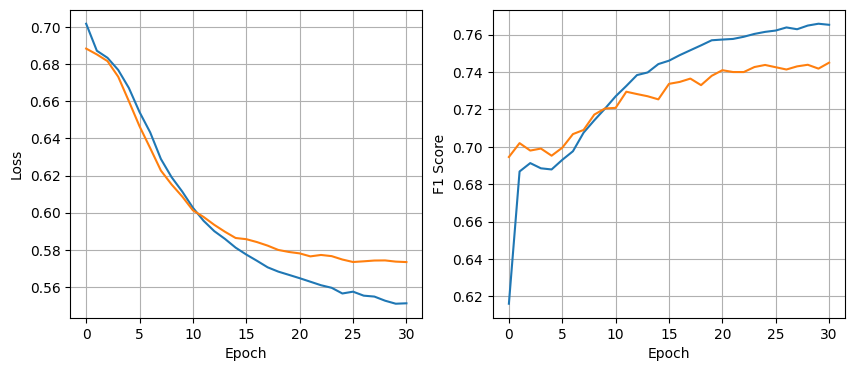

batch size: 256 - dropout: 0.25 - embedding dim 8 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



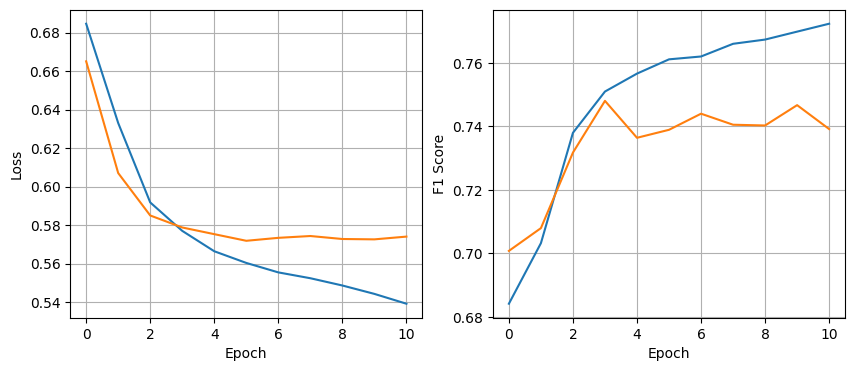

batch size: 256 - dropout: 0.25 - embedding dim 8 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06



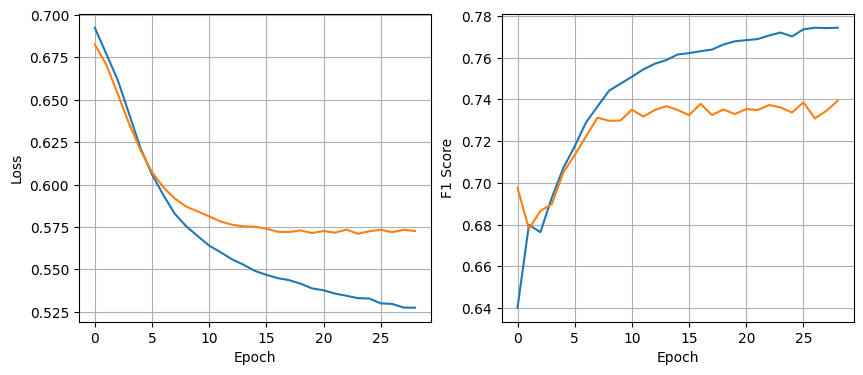

batch size: 256 - dropout: 0.25 - embedding dim 16 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



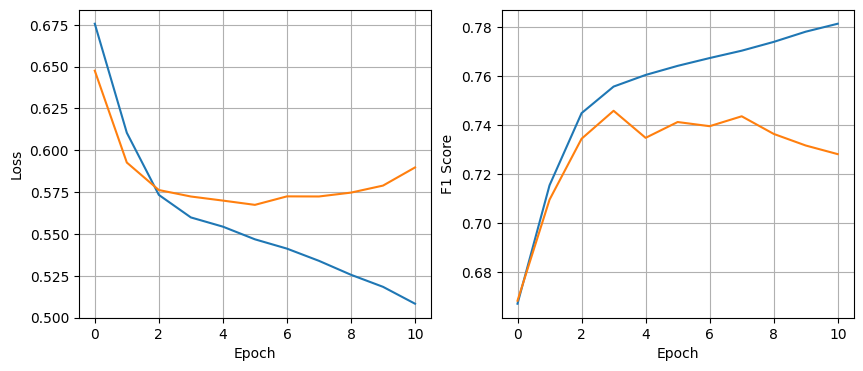

batch size: 256 - dropout: 0.25 - embedding dim 16 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06



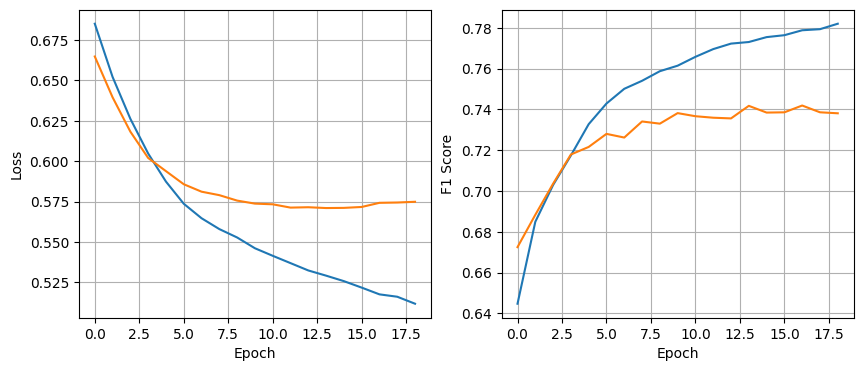

batch size: 256 - dropout: 0.25 - embedding dim 32 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



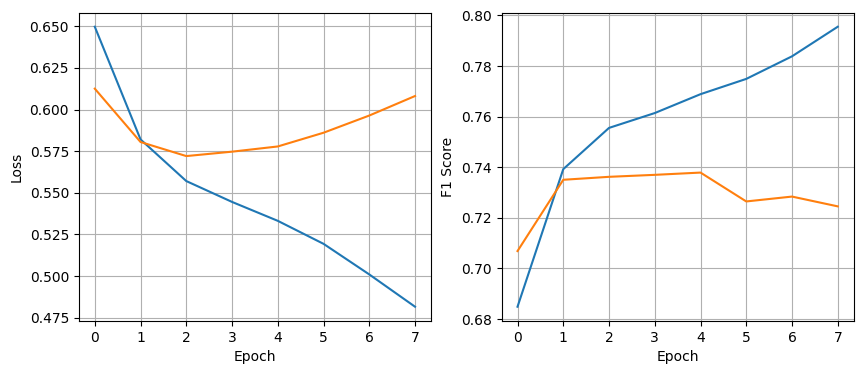

batch size: 256 - dropout: 0.25 - embedding dim 32 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06



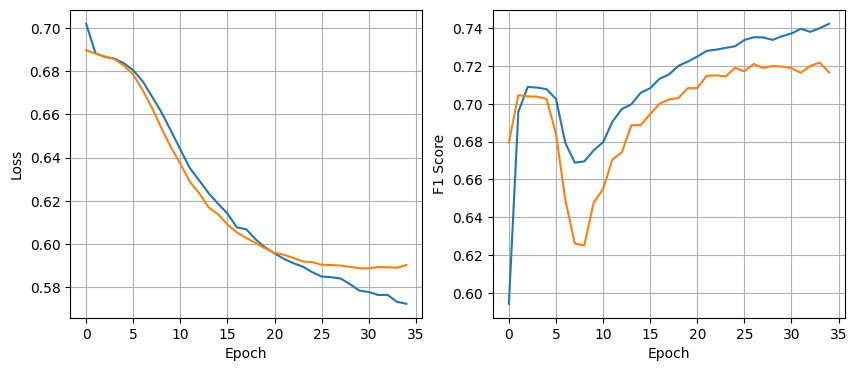

batch size: 256 - dropout: 0.5 - embedding dim 8 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



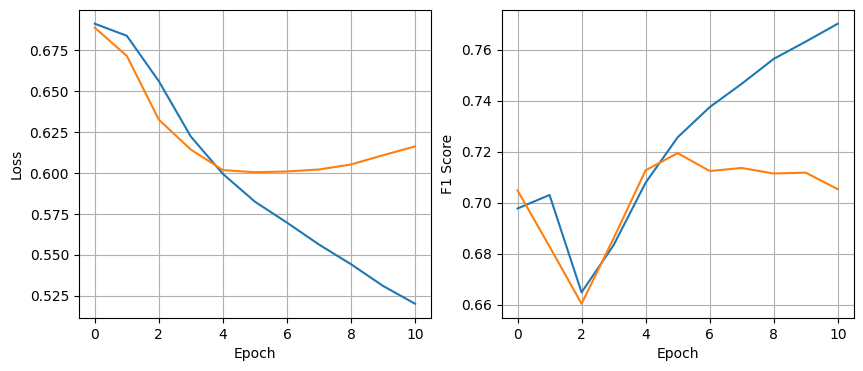

batch size: 256 - dropout: 0.5 - embedding dim 8 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06



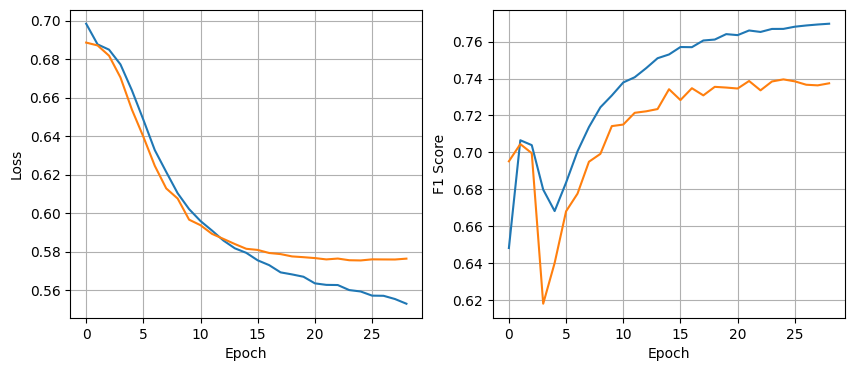

batch size: 256 - dropout: 0.5 - embedding dim 16 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



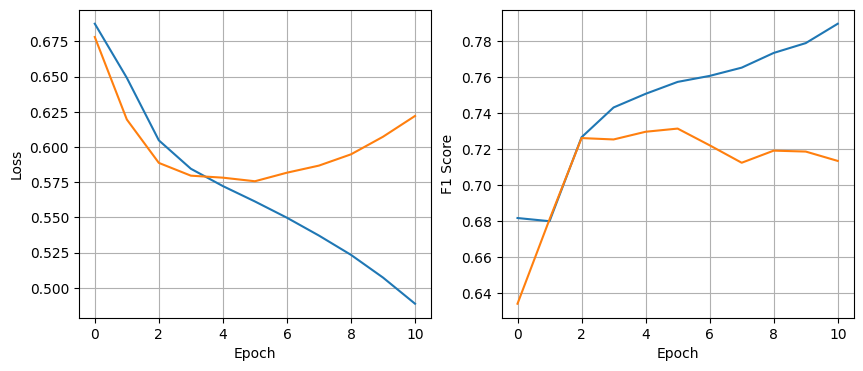

batch size: 256 - dropout: 0.5 - embedding dim 16 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06



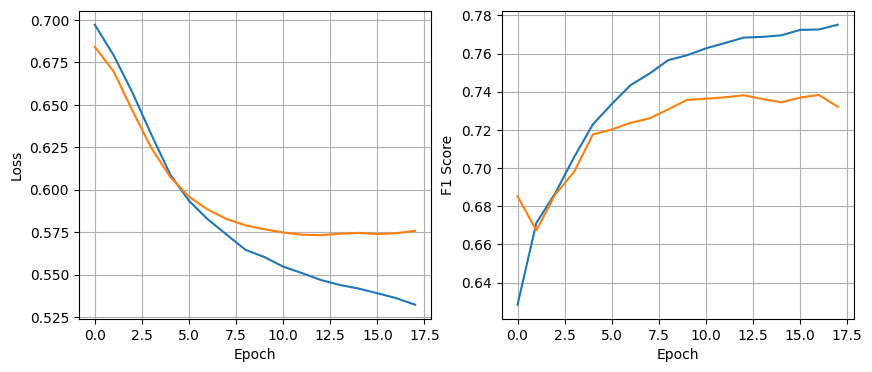

batch size: 256 - dropout: 0.5 - embedding dim 32 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



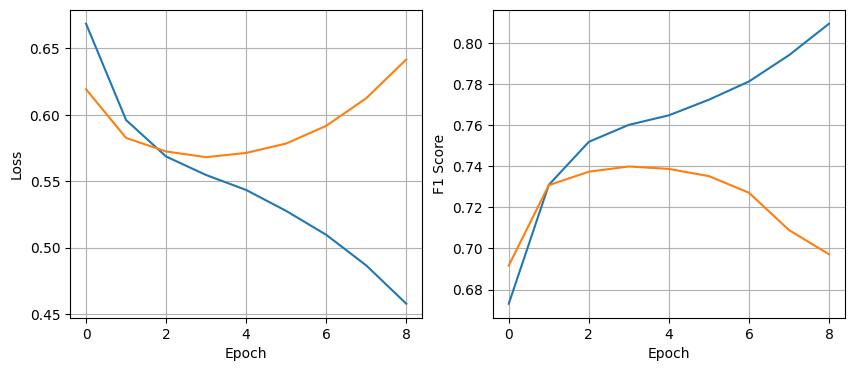

batch size: 256 - dropout: 0.5 - embedding dim 32 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06



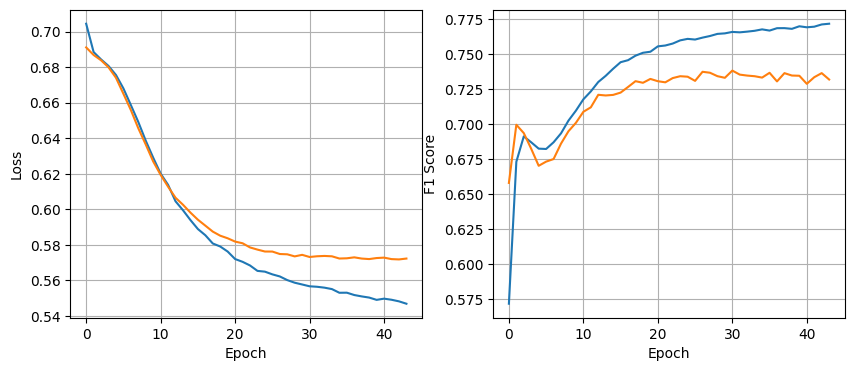

batch size: 512 - dropout: 0.25 - embedding dim 8 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



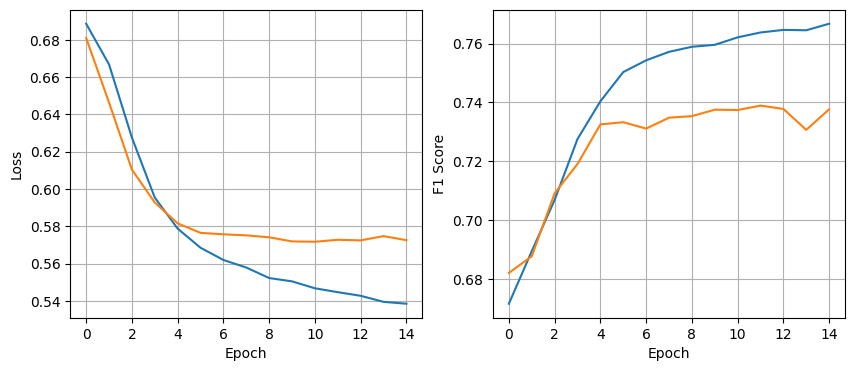

batch size: 512 - dropout: 0.25 - embedding dim 8 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06



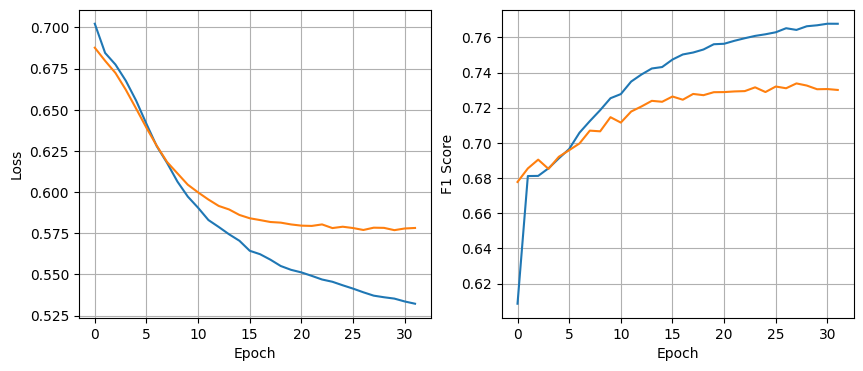

batch size: 512 - dropout: 0.25 - embedding dim 16 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



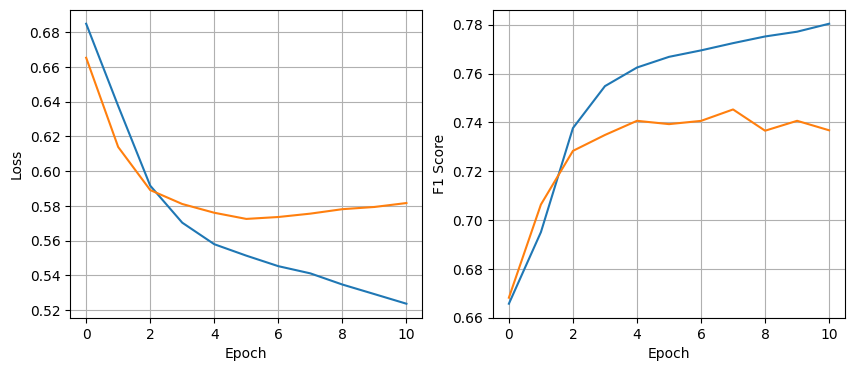

batch size: 512 - dropout: 0.25 - embedding dim 16 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06



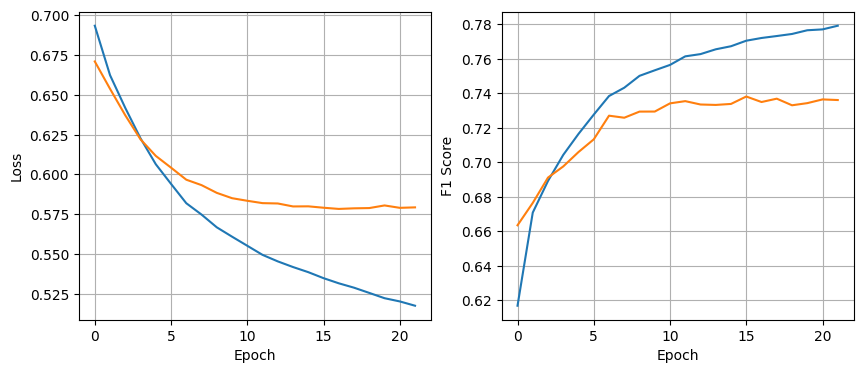

batch size: 512 - dropout: 0.25 - embedding dim 32 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



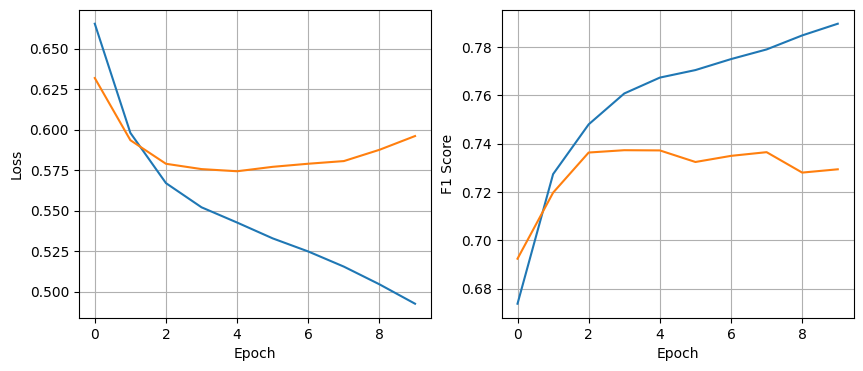

batch size: 512 - dropout: 0.25 - embedding dim 32 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06



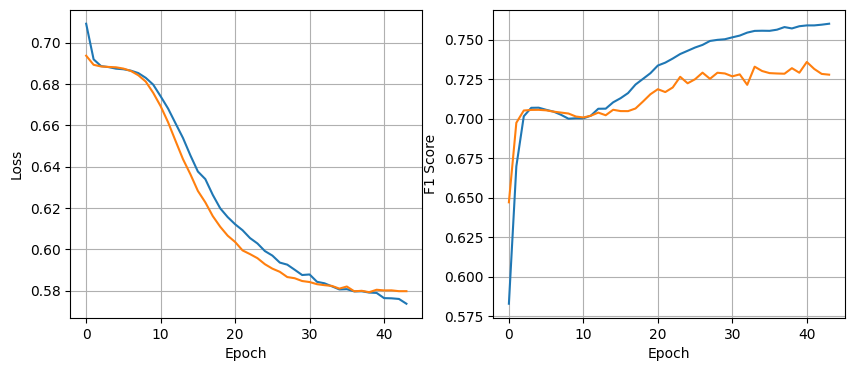

batch size: 512 - dropout: 0.5 - embedding dim 8 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



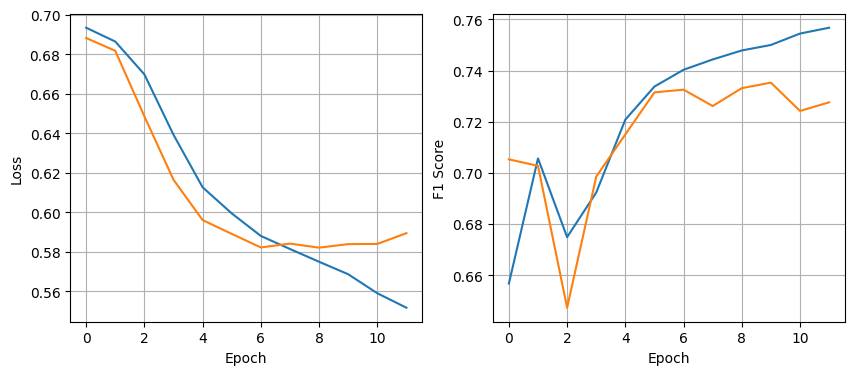

batch size: 512 - dropout: 0.5 - embedding dim 8 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06



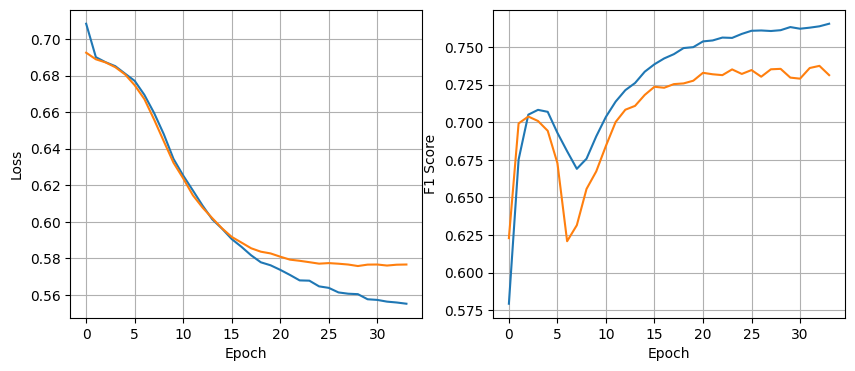

batch size: 512 - dropout: 0.5 - embedding dim 16 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



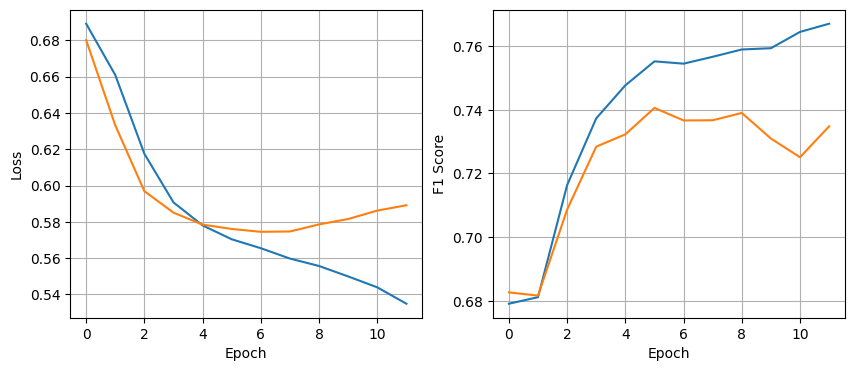

batch size: 512 - dropout: 0.5 - embedding dim 16 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06



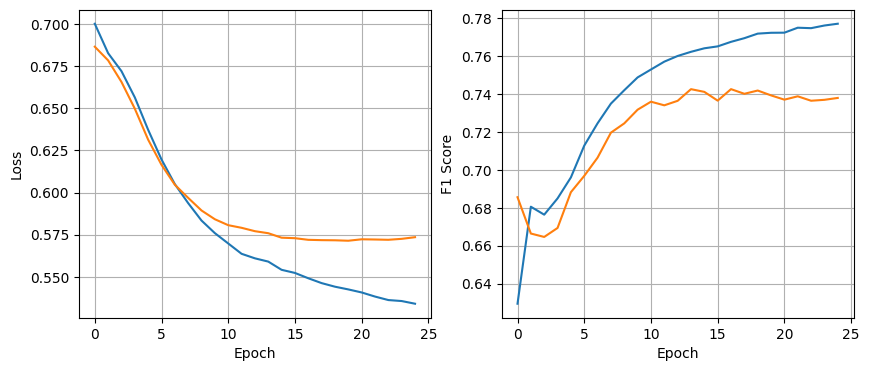

batch size: 512 - dropout: 0.5 - embedding dim 32 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



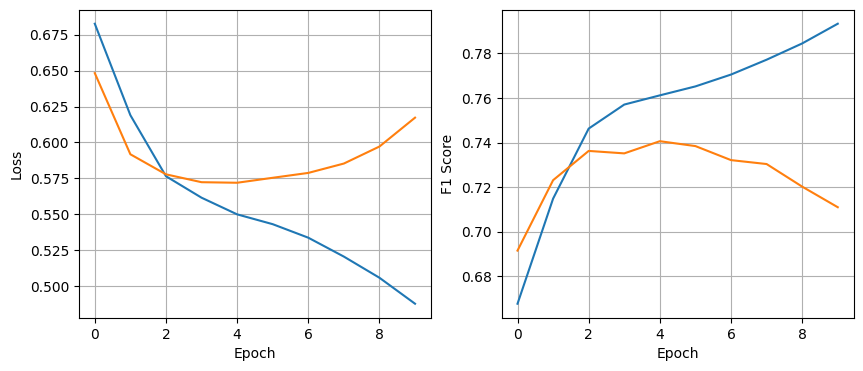

batch size: 512 - dropout: 0.5 - embedding dim 32 - learning rate: 0.005 - num hiddens: 3 - weight decay: 1e-06



In [39]:
for i, params in enumerate(hyperparameters):
    visualize_training(histories[i], params)

<a class='anchor' id='evaluation'></a>
# **Evaluation**

<a class='anchor' id='best-model'></a>
## *The Best Model*

In [106]:
def test_model(model, device, test_loader, criteria):
    model.to(device)    
    model.eval()
    test_loss = 0.0
    test_f1 = 0.0
    with torch.no_grad():
        progress_bar = tqdm(enumerate(test_loader), total=len(test_loader))
        for i, (batch_user_ids, batch_movie_ids, batch_ratings) in progress_bar:
            batch_user_ids = batch_user_ids.to(device)
            batch_movie_ids = batch_movie_ids.to(device)
            batch_ratings = batch_ratings.to(device)

            outputs = model(batch_user_ids, batch_movie_ids)
            loss = criteria(outputs, batch_ratings)
                
            test_loss = test_loss + loss.item() * batch_user_ids.size(0)
            test_f1 = test_f1 + binary_f1_score(outputs, batch_ratings) * batch_user_ids.size(0)

    test_loss /= len(test_loader.dataset)
    test_f1 /= len(test_loader.dataset)
    return test_loss, test_f1.item()

In [109]:
""" Test all experimental models """
test_losses = []
test_f1s = []
for i, model in enumerate(models):
    batch_size = hyperparameters[i][0]
    test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)
    test_loss, test_f1 = test_model(model, device, test_loader, nn.BCELoss())
    test_losses.append((i + 1, test_loss))
    test_f1s.append((i + 1, test_f1))

100%|██████████| 20/20 [00:00<00:00, 67.96it/s]


In [110]:
""" Sort test losses of all experimental models """
test_losses = sorted(test_losses, key=lambda item: item[1])
for test_loss in test_losses:
    print(f'{test_loss}  \t{hyperparameters[test_loss[0] - 1]}')

(13, 0.5705474879217759)  	(512, 0.25, 8, 0.001, 3, 1e-06)
(23, 0.5714108483683297)  	(512, 0.5, 32, 0.001, 3, 1e-06)
(21, 0.572196571379554)  	(512, 0.5, 16, 0.001, 3, 1e-06)
(2, 0.5729961703725379)  	(256, 0.25, 8, 0.005, 3, 1e-06)
(1, 0.5731966133506096)  	(256, 0.25, 8, 0.001, 3, 1e-06)
(14, 0.5732518136952544)  	(512, 0.25, 8, 0.005, 3, 1e-06)
(11, 0.5738617911749848)  	(256, 0.5, 32, 0.001, 3, 1e-06)
(3, 0.5743099688412721)  	(256, 0.25, 16, 0.001, 3, 1e-06)
(16, 0.5748506690522815)  	(512, 0.25, 16, 0.005, 3, 1e-06)
(9, 0.5760766400979965)  	(256, 0.5, 16, 0.001, 3, 1e-06)
(19, 0.5767751773731902)  	(512, 0.5, 8, 0.001, 3, 1e-06)
(5, 0.5769049455410322)  	(256, 0.25, 32, 0.001, 3, 1e-06)
(15, 0.5775103265201695)  	(512, 0.25, 16, 0.001, 3, 1e-06)
(17, 0.5796765744162699)  	(512, 0.25, 32, 0.001, 3, 1e-06)
(20, 0.5853990765877517)  	(512, 0.5, 8, 0.005, 3, 1e-06)
(4, 0.5857770711475344)  	(256, 0.25, 16, 0.005, 3, 1e-06)
(22, 0.5860158102873585)  	(512, 0.5, 16, 0.005, 3, 1e-06)


In [111]:
def construct_model_dict(idx):
    model_dict = {
        'idx': idx,
        'model': models[idx - 1],
        'history': histories[idx - 1],
        'params': hyperparameters[idx - 1]
    }
    return model_dict

=== The Best Model ===
# Index: 13
----------------------
# Architecture:
MovieRecommender(
  (user_embedding): Embedding(943, 8)
  (movie_embedding): Embedding(1682, 8)
  (mlp): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
  )
  (out): Linear(in_features=16, out_features=1, bias=True)
)



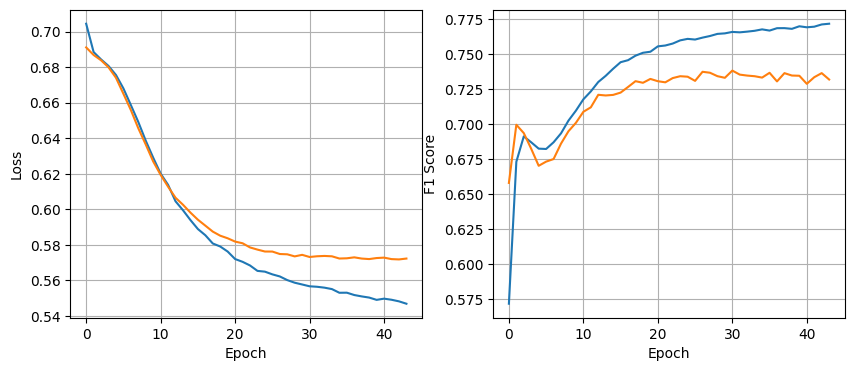

batch size: 512 - dropout: 0.25 - embedding dim 8 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



In [116]:
""" Get the model with the lowest loss """
top_idx = test_losses[0][0]
best_model = construct_model_dict(top_idx)
print('=== The Best Model ===')
print(f"# Index: {best_model['idx']}")
print('-' * 22)
print(f"# Architecture:\n{best_model['model']}\n")
visualize_training(best_model['history'], best_model['params'])

<a class='anchor' id='eval-rec'></a>
## *Evaluate Recommendation*

<div class='alert alert-block alert-info' style='font-weight: bold'>
    For each user, we will get a sample of <i>n</i> movies (predefined size) from all the movies that haven't rated by that user. Together with the movie rating generated before for evaluating, a list of <i>n + 1</i> will be fed into the recommendation model. The result of relevant scores between that user and the mentioned list of movies will be used to evaluate model performance through 2 metrics: HR@k and nDCG@k.
</div>

In [121]:
""" Generate a list of <n_samples> unrated movies """
def generate_eval_samples(eval_data, data_ratings, n_samples=100):
    for user in eval_data:
        rated_movies = data_ratings[data_ratings['user_id'] == user['user_id']]['movie_id'].tolist()
        unrated_movies = list(set(range(general_info['items'])) - set(rated_movies))
        sample_unrated_movies = random.sample(unrated_movies, n_samples)
        user['unrated_movies'] = sample_unrated_movies
    return eval_data

In [122]:
def predict_relevant_scores(model, user_id, movie_ids): # one user - all movies
    
    user_ids = torch.tensor([user_id] * len(movie_ids), dtype=torch.long)
    movie_ids = torch.tensor(movie_ids, dtype=torch.long)
    
    with torch.no_grad():
        user_ids = user_ids.to(device)
        movie_ids = movie_ids.to(device)
        outputs = model(user_ids, movie_ids)
        
    return outputs

In [123]:
def evaluate_recommendation(model, eval_data, data_ratings, k_values):
    
    hrs_at_k = [0.0] * len(k_values)
    ndcgs_at_k = [0.0] * len(k_values)
    
    for user in eval_data:
        """ Predict relevant scores """
        rel_scores = predict_relevant_scores(model, user['user_id'], [user['movie_id']] + user['unrated_movies'])
        rel_scores = zip(range(len(rel_scores)), rel_scores)
        rel_scores = sorted(rel_scores, key=lambda item: item[1], reverse=True)
        
        """ Evaluate through each top-k list """
        for k_idx, k in enumerate(k_values):
            top_k = rel_scores[:k]

            for i in range(k):
                if top_k[i][0] == 0:                
                    """ Calculate HR@k """
                    hrs_at_k[k_idx] += 1

                    """ Calculate nDCG@k """
                    ndcgs_at_k[k_idx] += (torch.log(torch.tensor(2)) / torch.log(torch.tensor(i + 2))).item()
                    break
    
    for i in range(len(k_values)):
        hrs_at_k[i] /= len(eval_data)
        ndcgs_at_k[i] /= len(eval_data)
    
    return hrs_at_k, ndcgs_at_k

In [169]:
markers = ['o', 's', '^', '*', 'P', 'X']
lines = ['-', ':', '--', '-.']
colors = ['r', 'g', 'b', 'c', 'm', 'y']

def format_plot_style(markers, lines, colors, n_plots):
    rand_m = random.sample(markers, n_plots)
    rand_l = random.sample(lines, n_plots)
    rand_c = random.sample(colors, n_plots)
    return [''.join([rand_m[i], rand_l[i], rand_c[i]]) for i in range(n_plots)]

def visualize_eval_metrics(all_hrs_at_k, all_ndcgs_at_k, labels, num_k):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    hr_plot_styles = format_plot_style(markers, lines, colors, len(all_hrs_at_k))
    hr_lines = []
    for i, hrs_at_k in enumerate(all_hrs_at_k):
        line, = ax1.plot(hrs_at_k, hr_plot_styles[i])
        hr_lines.append(line)
    ax1.legend(handles=hr_lines, labels=labels)
    ax1.set_xlabel('k')
    ax1.set_ylabel('HR@k')
    ax1.set_xticks(list(range(num_k)), list(range(1, num_k + 1)))
    ax1.grid(True)

    ndcg_plot_styles = format_plot_style(markers, lines, colors, len(all_ndcgs_at_k))
    ndcg_lines = []
    for i, ndcgs_at_k in enumerate(all_ndcgs_at_k):
        line, = ax2.plot(ndcgs_at_k, ndcg_plot_styles[i])
        ndcg_lines.append(line)
    ax2.legend(handles=ndcg_lines, labels=labels)
    ax2.set_xlabel('k')
    ax2.set_ylabel('nDCG@k')
    ax2.set_xticks(list(range(num_k)), list(range(1, num_k + 1)))
    ax2.grid(True)

    plt.show()

In [192]:
def display_eval_metrics(all_hrs_at_k, all_ndcgs_at_k, model_names, k_values):
    metric_names = ['HR@k', 'nDCG@k']
    multi_idx = pd.MultiIndex.from_product([model_names, metric_names])
    
    m_table = []
    for i in range(len(model_names)):
        m_table.append(all_hrs_at_k[i])
        m_table.append(all_ndcgs_at_k[i])
    return pd.DataFrame(m_table, index=multi_idx, columns=k_values)

In [124]:
n_samples = 100
k_values = list(range(1, 11))

In [125]:
sample_eval_data = generate_eval_samples(eval_data, df_ratings, n_samples)
print(sample_eval_data[0])

{'user_id': 0, 'movie_id': 255, 'rating': 4, 'unrated_movies': [446, 815, 1259, 1503, 323, 358, 632, 462, 673, 1025, 740, 1250, 1328, 668, 568, 773, 1524, 1024, 678, 1221, 560, 315, 1196, 1104, 991, 1251, 346, 840, 1427, 511, 1565, 368, 1460, 864, 1296, 1173, 1650, 902, 853, 938, 675, 722, 366, 791, 1439, 859, 620, 1447, 1469, 798, 823, 893, 1005, 1258, 1548, 771, 1642, 518, 812, 1101, 894, 870, 794, 1385, 744, 375, 385, 677, 750, 1654, 1476, 327, 1438, 279, 425, 1404, 1674, 1322, 1448, 694, 1403, 1421, 621, 345, 307, 989, 1288, 955, 1193, 1015, 1309, 873, 715, 550, 525, 707, 654, 906, 1377, 1426]}


<a class='anchor' id='eval-best-model'></a>
### Through The Best Model

In [171]:
bm_hrs_at_k, bm_ndcgs_at_k = evaluate_recommendation(best_model['model'], eval_data, df_ratings, k_values)

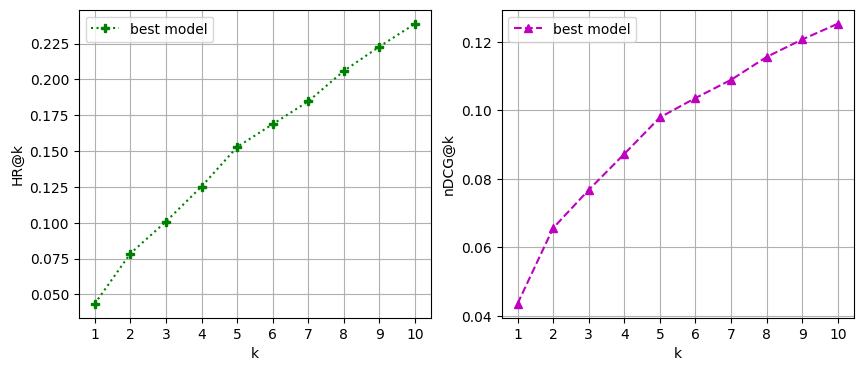

batch size: 512 - dropout: 0.25 - embedding dim: 8 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06


In [172]:
labels = ['best model']
visualize_eval_metrics([bm_hrs_at_k], [bm_ndcgs_at_k], labels, len(k_values))

(batch_size, dropout, embedding_dim, learning_rate, num_hiddens, weight_decay) = best_model['params']
print('=' * 60)
print(f'batch size: {batch_size} - dropout: {dropout} - embedding dim: {embedding_dim} ' +
      f'- learning rate: {learning_rate} - num hiddens: {num_hiddens} - weight decay: {weight_decay}')
print('=' * 60)

In [193]:
bm_metrics = display_eval_metrics([bm_hrs_at_k], [bm_ndcgs_at_k], ['Best model'], k_values)
bm_metrics

1         2         3         4         5         6   \
Best model HR@k    0.043524  0.078556  0.100849  0.125265  0.152866  0.168790   
           nDCG@k  0.043524  0.065627  0.076774  0.087289  0.097966  0.103639   

                         7         8         9         10  
Best model HR@k    0.184713  0.205945  0.222930  0.238854  
           nDCG@k  0.108946  0.115644  0.120757  0.125360

<a class='anchor' id='eval-embed-dims'></a>
### Through Embedding Dims

<div class='alert alert-block alert-info' style='font-weight: bold'>
    After manual observation, we decided to get the following set of hyperparameters to evaluate recommendation models through different embedding dims.
    <ul>
        <li>Batch size: 512</li>
        <li>Drop out rate: 0.5</li>
        <li>Learning rate: 1e-3</li>
        <li>Number of hidden layers: 3</li>
        <li>Weight decay: 1e-6</li>
    </ul>
    Embedding dim is in: [8, 16, 32]
</div>

In [194]:
picked_model_indices = [19, 21, 23]
picked_models = []
for x, idx in enumerate(picked_model_indices):
    picked_models.append(construct_model_dict(idx))
    print(picked_models[x]['params'])

(512, 0.5, 8, 0.001, 3, 1e-06)
(512, 0.5, 16, 0.001, 3, 1e-06)
(512, 0.5, 32, 0.001, 3, 1e-06)


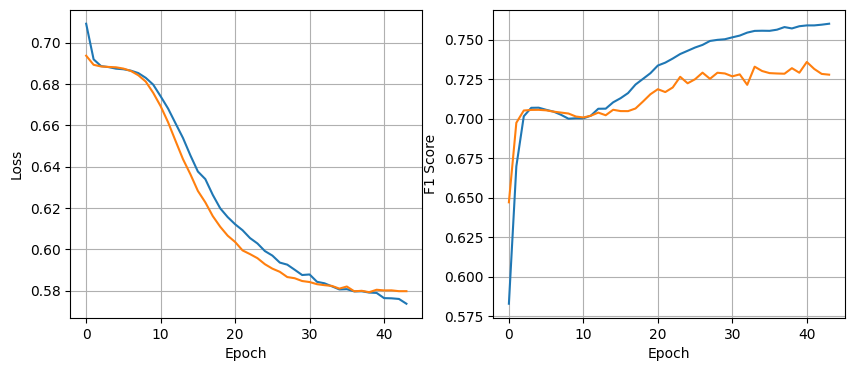

batch size: 512 - dropout: 0.5 - embedding dim 8 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



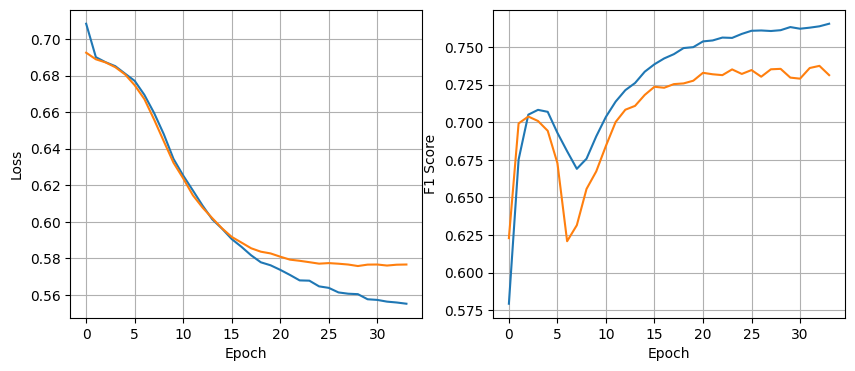

batch size: 512 - dropout: 0.5 - embedding dim 16 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



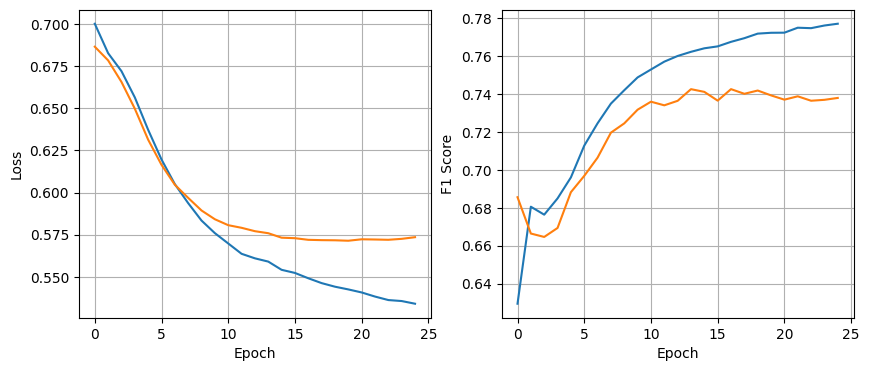

batch size: 512 - dropout: 0.5 - embedding dim 32 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06



In [207]:
for model in picked_models:
    visualize_training(model['history'], model['params'])

In [195]:
emb_hrs_at_k = []
emb_ndcgs_at_k = []
for model in picked_models:
    hrs_at_k, ndcgs_at_k = evaluate_recommendation(model['model'], eval_data, df_ratings, k_values)
    emb_hrs_at_k.append(hrs_at_k)
    emb_ndcgs_at_k.append(ndcgs_at_k)

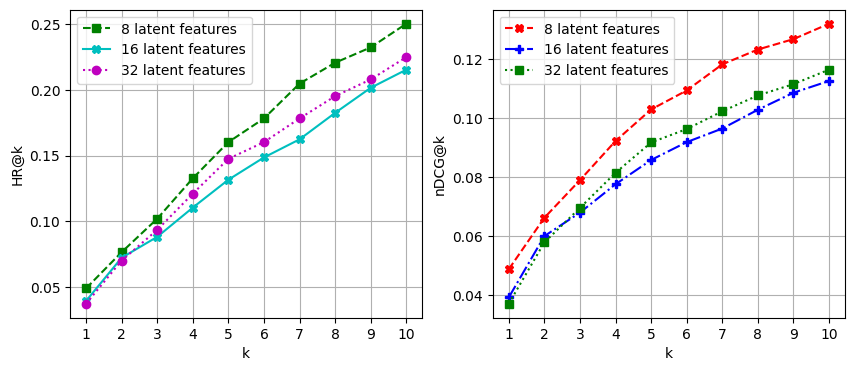

batch size: 512 - dropout: 0.5 - learning rate: 0.001 - num hiddens: 3 - weight decay: 1e-06


In [196]:
labels = [' '.join([str(dim), 'latent features']) for dim in embedding_dims]
visualize_eval_metrics(emb_hrs_at_k, emb_ndcgs_at_k, labels, len(k_values))

(batch_size, dropout, embedding_dim, learning_rate, num_hiddens, weight_decay) = picked_models[0]['params']
print('=' * 60)
print(f'batch size: {batch_size} - dropout: {dropout} ' +
      f'- learning rate: {learning_rate} - num hiddens: {num_hiddens} - weight decay: {weight_decay}')
print('=' * 60)

In [201]:
emb_model_names = [f'Model-{dim}LF' for dim in embedding_dims]
emb_metrics = display_eval_metrics(emb_hrs_at_k, emb_ndcgs_at_k, emb_model_names, k_values)
emb_metrics

1         2         3         4         5         6   \
Model-8LF  HR@k    0.048832  0.076433  0.101911  0.132696  0.160297  0.178344   
           nDCG@k  0.048832  0.066246  0.078985  0.092244  0.102921  0.109350   
Model-16LF HR@k    0.039278  0.072187  0.088110  0.110403  0.131635  0.148620   
           nDCG@k  0.039278  0.060041  0.068003  0.077604  0.085818  0.091868   
Model-32LF HR@k    0.037155  0.070064  0.093418  0.121019  0.147558  0.160297   
           nDCG@k  0.037155  0.057918  0.069595  0.081482  0.091749  0.096287   

                         7         8         9         10  
Model-8LF  HR@k    0.204883  0.220807  0.232484  0.250531  
           nDCG@k  0.118196  0.123220  0.126735  0.131951  
Model-16LF HR@k    0.162420  0.182590  0.201699  0.215499  
           nDCG@k  0.096468  0.102831  0.108583  0.112572  
Model-32LF HR@k    0.178344  0.195329  0.208068  0.225053  
           nDCG@k  0.102302  0.107661  0.111495  0.116405

<a class='anchor' id='recommend'></a>
## *Process Recommendation*

In [159]:
def get_user_rating_history(user_id):
    
    rt_hist = df_ratings[df_ratings['user_id'] == user_id].sort_values(by=['rating', 'timestamp'], ascending=False)
    rt_hist['title'] = rt_hist.apply(lambda row: df_movies[df_movies['movie_id'] == row['movie_id']].iloc[0]['title'], axis=1)
    
    return rt_hist

In [154]:
def recommend(model, user_id, n_movies=10, include_watched=True):
    
    rel_scores = predict_relevant_scores(model, user_id, list(range(0, general_info['items'])))
    desc_rel_scores = rel_scores.sort(descending=True)
    
    recommended_movies = []
    counts = 0
    for i, idx in enumerate(desc_rel_scores[1]):
            
        original_rating = df_ratings[(df_ratings['user_id'] == user_id) & (df_ratings['movie_id'] == int(idx))]
        if len(original_rating) > 0:
            original_rating = original_rating['rating'].iloc[0]
            if not include_watched:
                continue
        else:    
            original_rating = float('nan')
                
        recommended_movies.append((int(idx), df_movies['title'].iloc[int(idx)], original_rating, desc_rel_scores[0][i].item()))
        counts += 1
        if counts == n_movies:
            return recommended_movies
    
    return recommended_movies

In [202]:
ex_user_id = random.randint(0, general_info['users'] - 1)
n_movies = 20
include_watched = True
recommender = best_model['model']

In [205]:
recommended_movies = recommend(recommender, ex_user_id, n_movies, include_watched)
print(f'=' * 16)
print(f'User ID: {ex_user_id}')
print(f'=' * 16)
pd.DataFrame(recommended_movies, columns=['movie_id', 'title', 'rating', 'relevant_score'])

User ID: 875


,movie_id,title,rating,relevant_score
0,512,"Third Man, The (1949)",NaN,0.977570
1,317,Schindler's List (1993),5.0,0.971956
2,478,Vertigo (1958),NaN,0.969688
3,407,"Close Shave, A (1995)",NaN,0.968208
4,63,"Shawshank Redemption, The (1994)",NaN,0.967327
5,510,Lawrence of Arabia (1962),5.0,0.965057
6,497,"African Queen, The (1951)",NaN,0.962313
7,97,"Silence of the Lambs, The (1991)",NaN,0.961439
8,656,"Manchurian Candidate, The (1962)",NaN,0.960744
9,640,Paths of Glory (1957),NaN,0.957397


In [206]:
get_user_rating_history(ex_user_id).head(n_movies)

,user_id,movie_id,rating,timestamp,title
62796,875,47,5,879428481,Hoop Dreams (1994)
85542,875,603,5,879428406,It Happened One Night (1934)
85709,875,526,5,879428406,Gandhi (1982)
96491,875,317,5,879428406,Schindler's List (1993)
97507,875,522,5,879428378,Cool Hand Luke (1967)
69643,875,18,5,879428354,Antonia's Line (1995)
86057,875,510,5,879428354,Lawrence of Arabia (1962)
97502,875,285,5,879428072,"English Patient, The (1996)"
98725,875,530,4,879428481,Shine (1996)
75588,875,528,4,879428451,My Life as a Dog (Mitt liv som hund) (1985)
